In [2]:
#imports
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
from tqdm import tqdm
import scienceplots

from mrmr import mrmr_regression

from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
torch.manual_seed(4000)
np.random.seed(42)

### Data prepeparation

In [3]:
df=pd.read_csv('C:\\Users\\lucas\\Downloads\\laohuaYM_noAvg(2).csv',header=None,skiprows=1)

In [3]:
df_sorted=df.sort_values(by=1845)

In [5]:
train_df = pd.DataFrame(columns=df.columns)
test_df = pd.DataFrame(columns=df.columns)

for i in range(len(df)):
    if (i % 5) == 4:  # Adding every 5th row to the test_df
        test_df = pd.concat([test_df, df.iloc[[i]]], ignore_index=True)
    else:  # add other rows train
        train_df = pd.concat([train_df, df.iloc[[i]]], ignore_index=True)

In [6]:
x_train=train_df.iloc[:,0:1845]
y_train=train_df.iloc[:,1845]
x_test=test_df.iloc[:,0:1845]
y_test=test_df.iloc[:,1845]

In [7]:
x_train=pd.DataFrame(x_train)
y_train=pd.Series(y_train.ravel())

x_test=pd.DataFrame(x_test)
y_test=pd.Series(y_test.ravel())

In [8]:
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [75]:
selected_features=mrmr_regression(X=x_train,
                                      y=y_train,
                                      K=1846)

KeyboardInterrupt: 

In [61]:
mi_scores=mutual_info_regression(x_train,y_train,n_neighbors=3)

### Filter Methods

In [9]:
#### can mutual information // mrmr improve the lowest cv's performance for a PLS?

In [10]:
#what is the best one with full spectra?
test_arr=[]
train_arr=[]
for i in range(1,30):
    pls=PLSRegression(n_components=i)
    pls.fit(x_train,y_train)
    train_arr.append(r2_score(y_train,pls.predict(x_train)))
    test_arr.append(r2_score(y_test,pls.predict(x_test)))

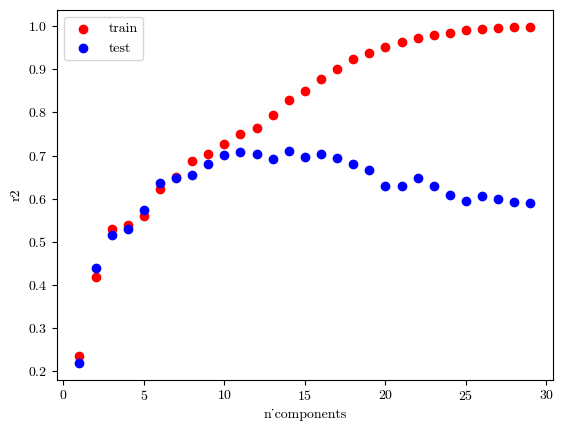

In [11]:
plt.style.use('no-latex')

plt.scatter(range(1,30),train_arr,color='red',label='train')
plt.scatter(range(1,30),test_arr,color='blue',label='test')
plt.ylabel('r2')
plt.xlabel('n_components')
plt.legend()

In [12]:
#lowest cv full spectra
param_grid = {'n_components':np.arange(1,30)}
rkf=RepeatedKFold(n_splits=5,n_repeats=5)
grid_search = GridSearchCV(PLSRegression(), param_grid, cv=rkf, scoring='r2', n_jobs=-1)
grid_search.fit(x_train, y_train)
grid_search.best_params_

{'n_components': 16}

In [13]:
### best cv is obtained with 15 to 17 components, predicted r2 at this valus is about 0.7
pls=PLSRegression(n_components=16)
pls.fit(x_train,y_train)
train=r2_score(y_train,pls.predict(x_train))
test=r2_score(y_test,pls.predict(x_test))
print(test)

0.7038826598179051


In [357]:
#now, can we improve with mrmr or mi?
#lets try mi first.

def mutual_information_improve_pls(x_train,y_train,x_test,y_test):
    
    columns = ['top_n', 'CV', 'train r2', 'test r2', 'n_components']
    stored = pd.DataFrame(columns=columns)
    
    param_grid = {'n_components':np.arange(1,30)}
    
    #get scores
    mi_scores=mutual_info_regression(x_train,y_train,n_neighbors=3,random_state=42)
    
    for i in tqdm(range(x_train.shape[1],1,-25)):
    
        important_idx=np.sort(pd.Series(mi_scores).sort_values(ascending=False).head(i).index)
        
        x_train_important = x_train.iloc[:, important_idx].sort_index(axis=1)
        x_test_important = x_test.iloc[:, important_idx].sort_index(axis=1)
        
        pls=PLSRegression()
        rkf = RepeatedKFold(n_splits=5, n_repeats=5)
        grid_search = GridSearchCV(pls, param_grid, cv=rkf, scoring='r2', n_jobs=-1)
        grid_search.fit(x_train_important, y_train)
        
        n_components=grid_search.best_params_['n_components']
        cv=grid_search.best_score_
        
        pls=PLSRegression(n_components=n_components)
        pls.fit(x_train_important,y_train)
        train_r2=r2_score(y_train,pls.predict(x_train_important))
        test_r2=r2_score(y_test,pls.predict(x_test_important))
        
        stored.loc[i] = [i, cv, train_r2, test_r2, n_components]
        
    return stored

In [358]:
table=mutual_information_improve_pls(x_train=x_train,
                                     y_train=y_train,
                                     x_test=x_test,
                                     y_test=y_test)

100%|██████████| 74/74 [13:40<00:00, 11.09s/it]


In [254]:
table

,top_n,CV,train r2,test r2,n_components
1845,1845.0,0.669894,0.899558,0.693555,17.0
1820,1820.0,0.680371,0.879048,0.703646,16.0
1795,1795.0,0.690539,0.857637,0.693299,15.0
1770,1770.0,0.661787,0.857875,0.701467,15.0
1745,1745.0,0.681243,0.904069,0.695496,17.0
...,...,...,...,...,...
120,120.0,0.516010,0.622426,0.556580,6.0
95,95.0,0.488665,0.612560,0.530862,6.0
70,70.0,0.488585,0.602157,0.525400,6.0
45,45.0,0.426816,0.542659,0.476882,6.0


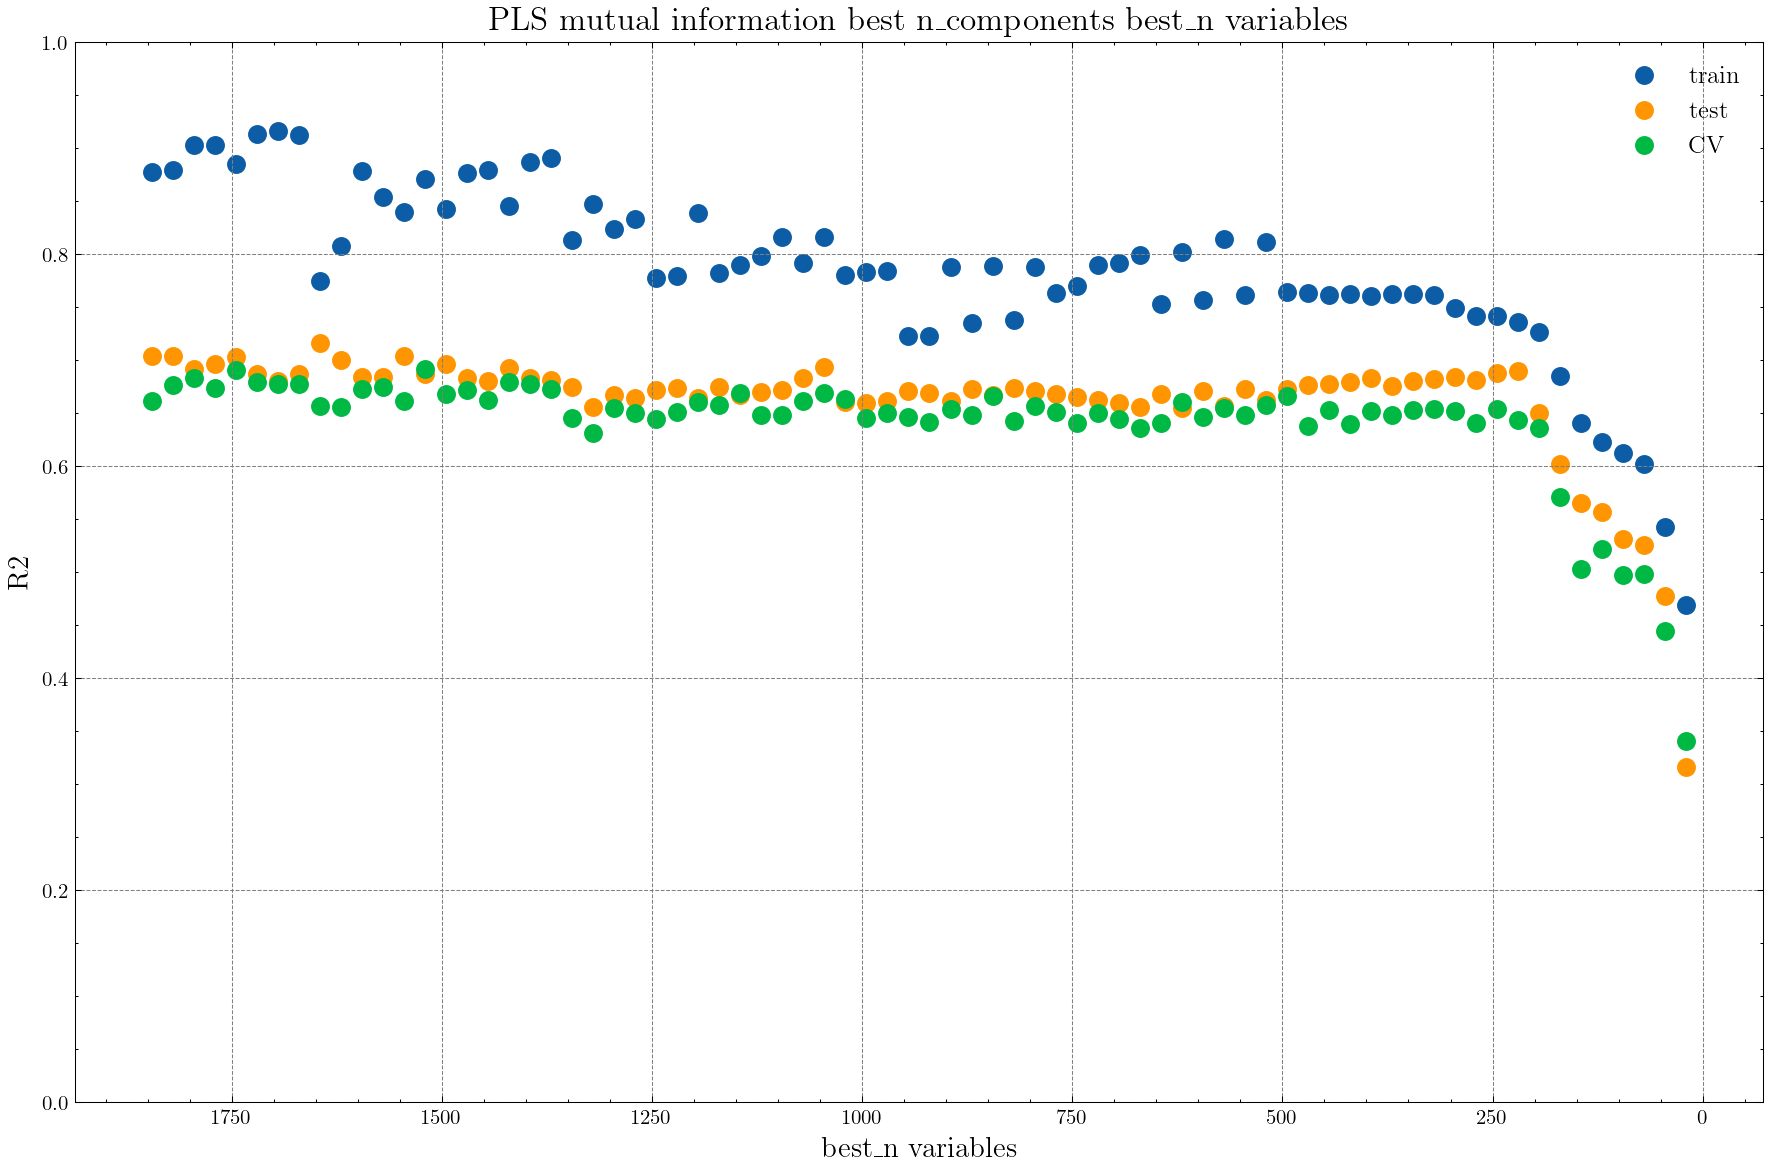

In [368]:
plt.style.use('science')

plt.figure(figsize=(12, 8), dpi=200)  # Increase the DPI for better quality

plt.scatter(table['top_n'], table['train r2'], color='C0', s=50, marker='o', label='train', linewidths=2)
plt.scatter(table['top_n'], table['test r2'], color='C2', s=50, marker='o', label='test', linewidths=2)
plt.scatter(table['top_n'], table['CV'], color='C1', s=50, marker='o', label='CV', linewidths=2)

plt.ylim(0, 1)
plt.gca().invert_xaxis()

plt.ylabel('R2', fontsize=14)
plt.xlabel('best_n variables', fontsize=14)
plt.title('PLS mutual information best n_components best_n variables', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')  # Subtle grid lines

plt.legend(fontsize=12)
plt.tight_layout()  # This can help with fitting everything neatly

In [41]:
def mrmr_improve_pls(x_train,y_train,x_test,y_test):
   
    columns = ['top_n', 'CV', 'train r2', 'test r2', 'n_components', 'std_cv_score']
    stored = pd.DataFrame(columns=columns)
   
    param_grid = {'n_components':np.arange(1,30)}
   
    #get scores
    selected_features=mrmr_regression(X=x_train,
                                  y=y_train,
                                  K=x_train.shape[1])
   
    for i in tqdm(range(x_train.shape[1],31,-35)):
   
        important_idx=selected_features[0:i]
       
        x_train_important = x_train.iloc[:, important_idx].sort_index(axis=1)
        x_test_important = x_test.iloc[:, important_idx].sort_index(axis=1)
       
        pls=PLSRegression()
        rkf = RepeatedKFold(n_splits=5, n_repeats=5)
        grid_search = GridSearchCV(pls, param_grid, cv=rkf, scoring='r2', n_jobs=-1)
        grid_search.fit(x_train_important, y_train)
       
        n_components=grid_search.best_params_['n_components']
        cv=grid_search.best_score_
       
        pls=PLSRegression(n_components=n_components)
        cv_scores = cross_val_score(pls, x_train_important, y_train, cv=rkf, scoring='r2')
        std_cv_score = cv_scores.std()
       
        pls.fit(x_train_important,y_train)
        train_r2=r2_score(y_train,pls.predict(x_train_important))
        test_r2=r2_score(y_test,pls.predict(x_test_important))
       
        stored.loc[i] = [i, cv, train_r2, test_r2, n_components, std_cv_score]
       
    return stored

In [42]:
table=mrmr_improve_pls(x_train=x_train,
                                     y_train=y_train,
                                     x_test=x_test,
                                     y_test=y_test)

100%|██████████| 52/52 [10:46<00:00, 12.44s/it]


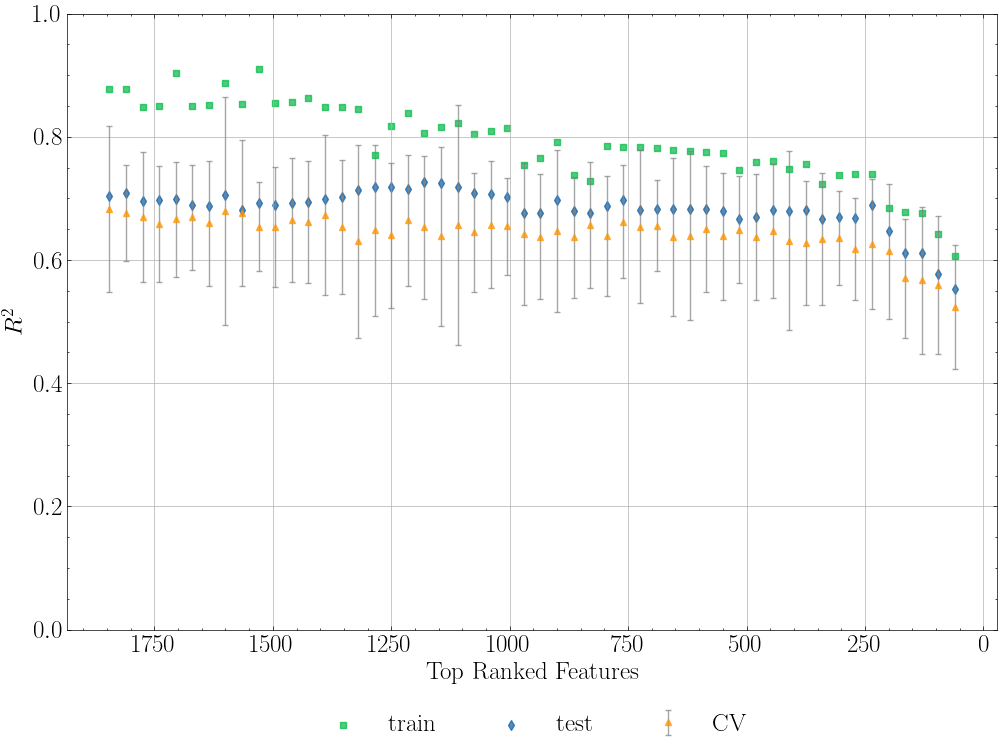

In [43]:
import scienceplots
plt.style.use('science')
plt.figure(figsize=(12, 8))  # Increased figure size for better clarity

#plt.errorbar(table.index[::-1], table['train mse'][::-1], yerr=table['train std'][::-1], fmt='o', markersize=5, capsize=2, label='Train MSE', color='blue', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.scatter(table.index[::-1], table['train r2'][::-1], marker='s', s=25, label='train', color='C1', alpha=0.7)
plt.scatter(table.index[::-1], table['test r2'][::-1], marker='d', s=25, label='test', color='C0', alpha=0.7)
plt.errorbar(table.index[::-1], table['CV'][::-1], yerr=table['std_cv_score'][::-1], fmt='^', markersize=5, capsize=2, label='CV', color='C2', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')

plt.xlabel('Top Ranked Features', fontsize=18)
plt.ylabel('$R^2$', fontsize=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)


plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=4,fontsize=18)
plt.ylim(0,1)
plt.gca().invert_xaxis()  # Keep the x-axis inverted

plt.savefig('C:\\Users\\lucas\\Downloads\\PLS_mrmr_variable_dataset2.pdf', format='pdf', bbox_inches='tight')

In [44]:
def mrmr_improve_svr(x_train,y_train,x_test,y_test):
   
    columns = ['top_n', 'CV', 'train r2', 'test r2', 'std_cv_score']
    stored = pd.DataFrame(columns=columns)
   
    #get scores
    selected_features=mrmr_regression(X=x_train,
                                  y=y_train,
                                  K=x_train.shape[1])
   
    for i in tqdm(range(x_train.shape[1],31,-35)):
   
        important_idx=selected_features[0:i]
       
        x_train_important = x_train.iloc[:, important_idx].sort_index(axis=1)
        x_test_important = x_test.iloc[:, important_idx].sort_index(axis=1)
       
        svr = SVR(kernel='linear')
        rkf = RepeatedKFold(n_splits=5, n_repeats=5)
       
        cv_scores = cross_val_score(svr, x_train_important, y_train, cv=rkf, scoring='r2')
        cv = cv_scores.mean()
        std_cv_score = cv_scores.std()
       
        svr.fit(x_train_important, y_train)
        train_r2 = r2_score(y_train, svr.predict(x_train_important))
        test_r2 = r2_score(y_test, svr.predict(x_test_important))
       
        stored.loc[i] = [i, cv, train_r2, test_r2, std_cv_score]
       
    return stored

In [45]:
table=mrmr_improve_svr(x_train=x_train,
                       y_train=y_train,
                       x_test=x_test,
                       y_test=y_test)

100%|██████████| 52/52 [00:43<00:00,  1.19it/s]


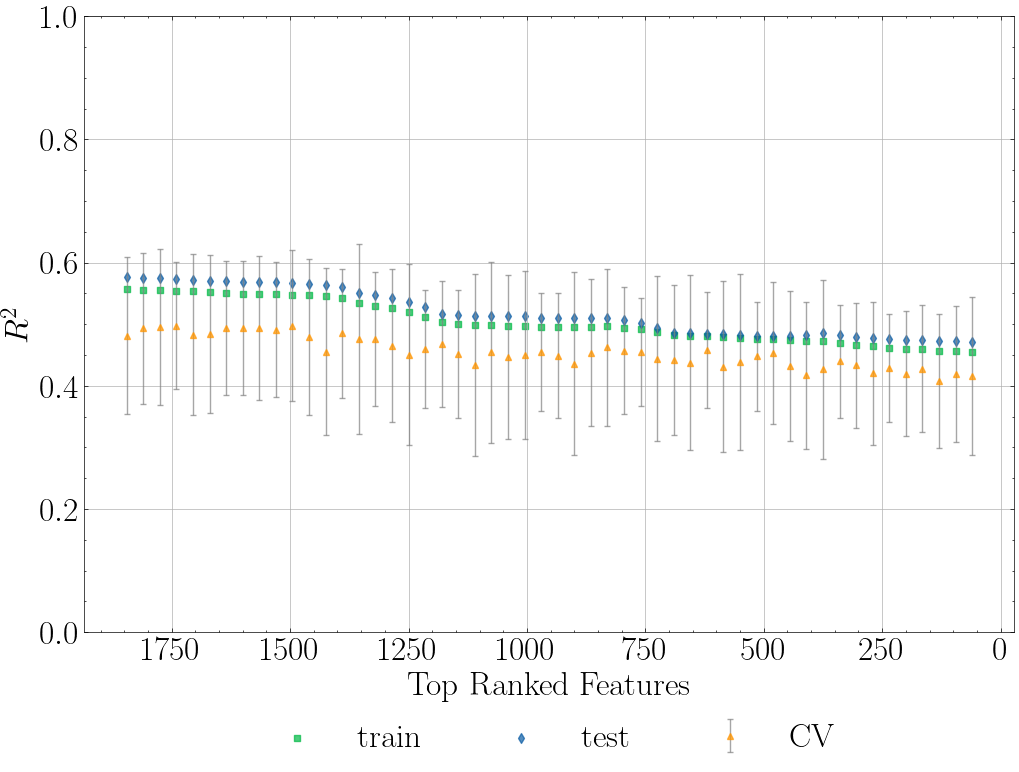

In [49]:
import scienceplots
plt.style.use('science')
plt.figure(figsize=(12, 8))  # Increased figure size for better clarity

#plt.errorbar(table.index[::-1], table['train mse'][::-1], yerr=table['train std'][::-1], fmt='o', markersize=5, capsize=2, label='Train MSE', color='blue', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.scatter(table.index[::-1], table['train r2'][::-1], marker='s', s=25, label='train', color='C1', alpha=0.7)
plt.scatter(table.index[::-1], table['test r2'][::-1], marker='d', s=25, label='test', color='C0', alpha=0.7)
plt.errorbar(table.index[::-1], table['CV'][::-1], yerr=table['std_cv_score'][::-1], fmt='^', markersize=5, capsize=2, label='CV', color='C2', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')

plt.xlabel('Top Ranked Features', fontsize=24)
plt.ylabel('$R^2$', fontsize=24)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid(True)


plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=4,fontsize=24)
plt.ylim(0,1)
plt.gca().invert_xaxis()  # Keep the x-axis inverted

plt.savefig('C:\\Users\\lucas\\Downloads\\SVM_fixed_dataset2.pdf', format='pdf', bbox_inches='tight')

In [ ]:
#what about if we fix the n_components?

In [62]:
def mrmr_improve_pls_fixed(x_train, y_train, x_test, y_test, n_components):
    columns = ['top_n', 'CV', 'train r2', 'test r2', 'n_components', 'std_cv_score']
    stored = pd.DataFrame(columns=columns)
   
    # Get scores
    selected_features = mrmr_regression(X=x_train,
                                        y=y_train,
                                        K=x_train.shape[1])
   
    for i in tqdm(range(x_train.shape[1], 31, -35)):
        important_idx = selected_features[0:i]
       
        x_train_important = x_train.iloc[:, important_idx].sort_index(axis=1)
        x_test_important = x_test.iloc[:, important_idx].sort_index(axis=1)
       
        rkf = RepeatedKFold(n_splits=5, n_repeats=5)
       
        pls = PLSRegression(n_components=n_components)
        cv_scores = cross_val_score(pls, x_train_important, y_train, cv=rkf, scoring='r2')
        cv = cv_scores.mean()
        std_cv_score = cv_scores.std()
       
        pls.fit(x_train_important, y_train)
        train_r2 = r2_score(y_train, pls.predict(x_train_important))
        test_r2 = r2_score(y_test, pls.predict(x_test_important))
       
        stored.loc[i] = [i, cv, train_r2, test_r2, n_components, std_cv_score]
       
    return stored

In [63]:
table=mrmr_improve_pls_fixed(x_train=x_train, 
                             y_train=y_train, 
                             x_test=x_test, 
                             y_test=y_test, 
                             n_components=10)

KeyboardInterrupt: 

In [ ]:
table

,top_n,CV,train r2,test r2,n_components,std_cv_score
1845,1845.0,0.674170,0.877474,0.703883,16.0,0.128769
1810,1810.0,0.670974,0.877992,0.709178,16.0,0.067468
1775,1775.0,0.674317,0.881177,0.711046,16.0,0.077159
1740,1740.0,0.682339,0.886388,0.713772,16.0,0.083872
1705,1705.0,0.644167,0.889538,0.708779,16.0,0.150470
1670,1670.0,0.648753,0.890229,0.704814,16.0,0.128200
1635,1635.0,0.649064,0.889359,0.705708,16.0,0.125404
1600,1600.0,0.651055,0.886591,0.704924,16.0,0.112608
1565,1565.0,0.667286,0.881816,0.705610,16.0,0.096306
1530,1530.0,0.655097,0.882154,0.708523,16.0,0.082236


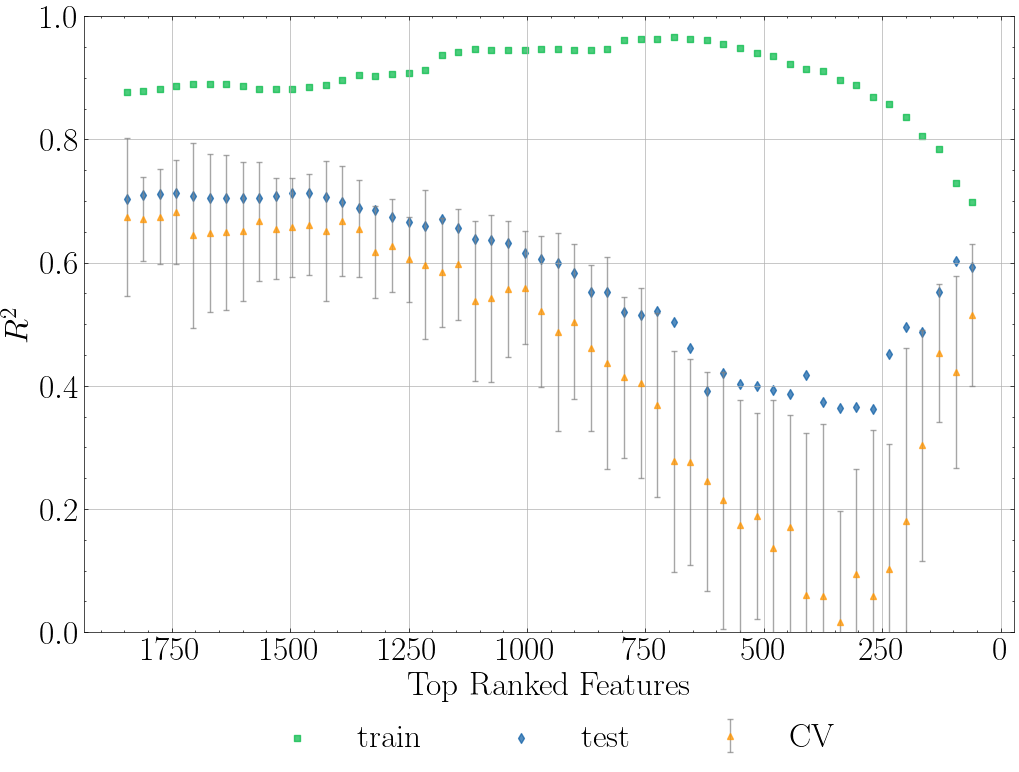

In [59]:
import scienceplots
plt.style.use('science')
plt.figure(figsize=(12, 8))  # Increased figure size for better clarity

#plt.errorbar(table.index[::-1], table['train mse'][::-1], yerr=table['train std'][::-1], fmt='o', markersize=5, capsize=2, label='Train MSE', color='blue', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.scatter(table.index[::-1], table['train r2'][::-1], marker='s', s=25, label='train', color='C1', alpha=0.7)
plt.scatter(table.index[::-1], table['test r2'][::-1], marker='d', s=25, label='test', color='C0', alpha=0.7)
plt.errorbar(table.index[::-1], table['CV'][::-1], yerr=table['std_cv_score'][::-1], fmt='^', markersize=5, capsize=2, label='CV', color='C2', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')

plt.xlabel('Top Ranked Features', fontsize=24)
plt.ylabel('$R^2$', fontsize=24)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid(True)


plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=4,fontsize=24)
plt.ylim(0,1)
plt.gca().invert_xaxis()  # Keep the x-axis inverted

plt.savefig('C:\\Users\\lucas\\Downloads\\PLS_fixed_dataset2.pdf', format='pdf', bbox_inches='tight')

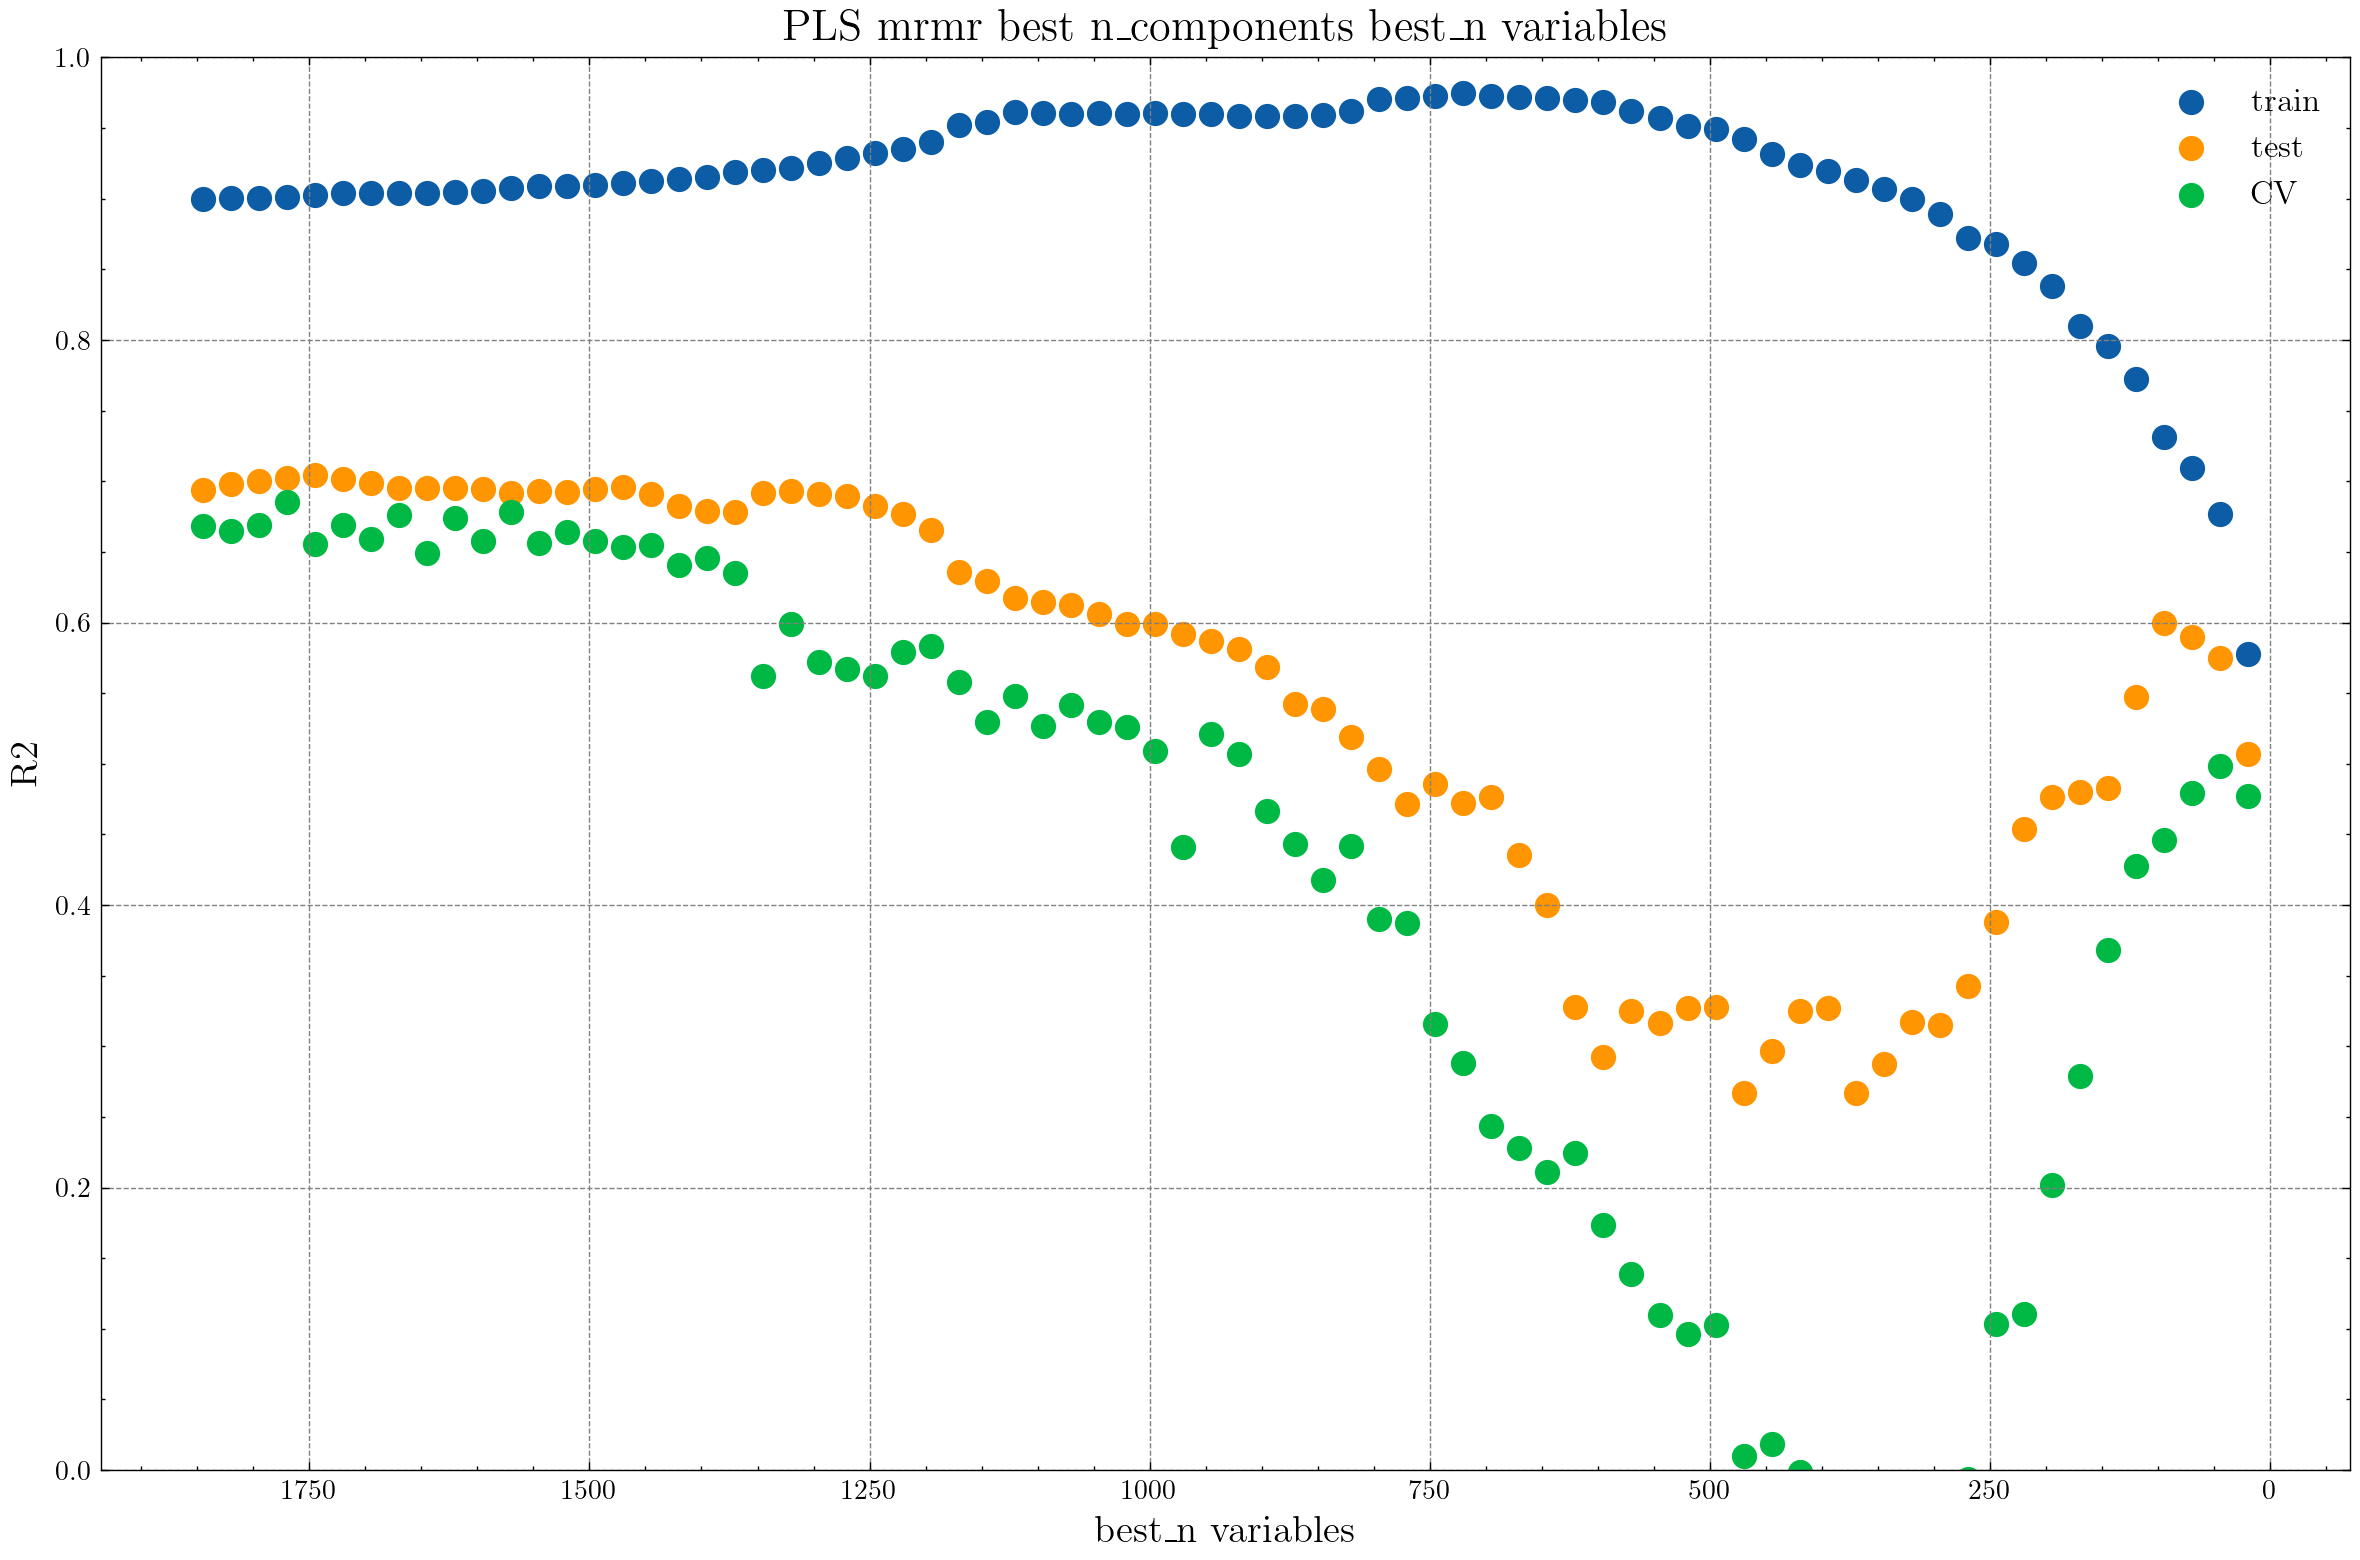

In [44]:
plt.style.use('science')

plt.figure(figsize=(12, 8), dpi=200)  # Increase the DPI for better quality

plt.scatter(table['top_n'], table['train r2'], color='C0', s=50, marker='o', label='train', linewidths=2)
plt.scatter(table['top_n'], table['test r2'], color='C2', s=50, marker='o', label='test', linewidths=2)
plt.scatter(table['top_n'], table['CV'], color='C1', s=50, marker='o', label='CV', linewidths=2)

plt.ylim(0, 1)
plt.gca().invert_xaxis()

plt.ylabel('R2', fontsize=14)
plt.xlabel('best_n variables', fontsize=14)
plt.title('PLS mrmr best n_components best_n variables', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')  # Subtle grid lines

plt.legend(fontsize=12)
plt.tight_layout()  # This can help with fitting everything neatly

In [37]:
def mi_improve_pls_fixed_n_components(x_train,y_train,x_test,y_test):
    
    columns = ['top_n', 'CV', 'train r2', 'test r2']
    stored = pd.DataFrame(columns=columns)
    
    #get scores
    mi_scores=mutual_info_regression(x_train,y_train,n_neighbors=3,random_state=42)
    
    for i in tqdm(range(x_train.shape[1],1,-25)):
    
        important_idx=np.sort(pd.Series(mi_scores).sort_values(ascending=False).head(i).index)
        
        x_train_important = x_train.iloc[:, important_idx].sort_index(axis=1)
        x_test_important = x_test.iloc[:, important_idx].sort_index(axis=1)
        
        pls=PLSRegression(n_components=14)
        rkf = RepeatedKFold(n_splits=5, n_repeats=5)
        
        cv_scores = cross_val_score(pls, x_train_important, y_train, cv=rkf, scoring='r2')
        mean_cv_score = np.mean(cv_scores)
        
        pls=PLSRegression(n_components=14)
        pls.fit(x_train_important,y_train)
        train_r2=r2_score(y_train,pls.predict(x_train_important))
        test_r2=r2_score(y_test,pls.predict(x_test_important))
        
        stored.loc[i] = [i, mean_cv_score, train_r2, test_r2]
        
    return stored

In [38]:
table=mi_improve_pls_fixed_n_components(x_train=x_train,
                                          y_train=y_train,
                                          x_test=x_test,
                                          y_test=y_test)

100%|██████████| 74/74 [01:32<00:00,  1.25s/it]


In [39]:
table

,top_n,CV,train r2,test r2
1845,1845.0,0.680861,0.829504,0.709369
1820,1820.0,0.670985,0.834538,0.711112
1795,1795.0,0.684728,0.842267,0.712051
1770,1770.0,0.633392,0.843066,0.717253
1745,1745.0,0.647585,0.845169,0.719913
...,...,...,...,...
120,120.0,0.292341,0.721671,0.350020
95,95.0,0.370852,0.712003,0.285642
70,70.0,0.339964,0.663689,0.530104
45,45.0,0.374401,0.600642,0.499873


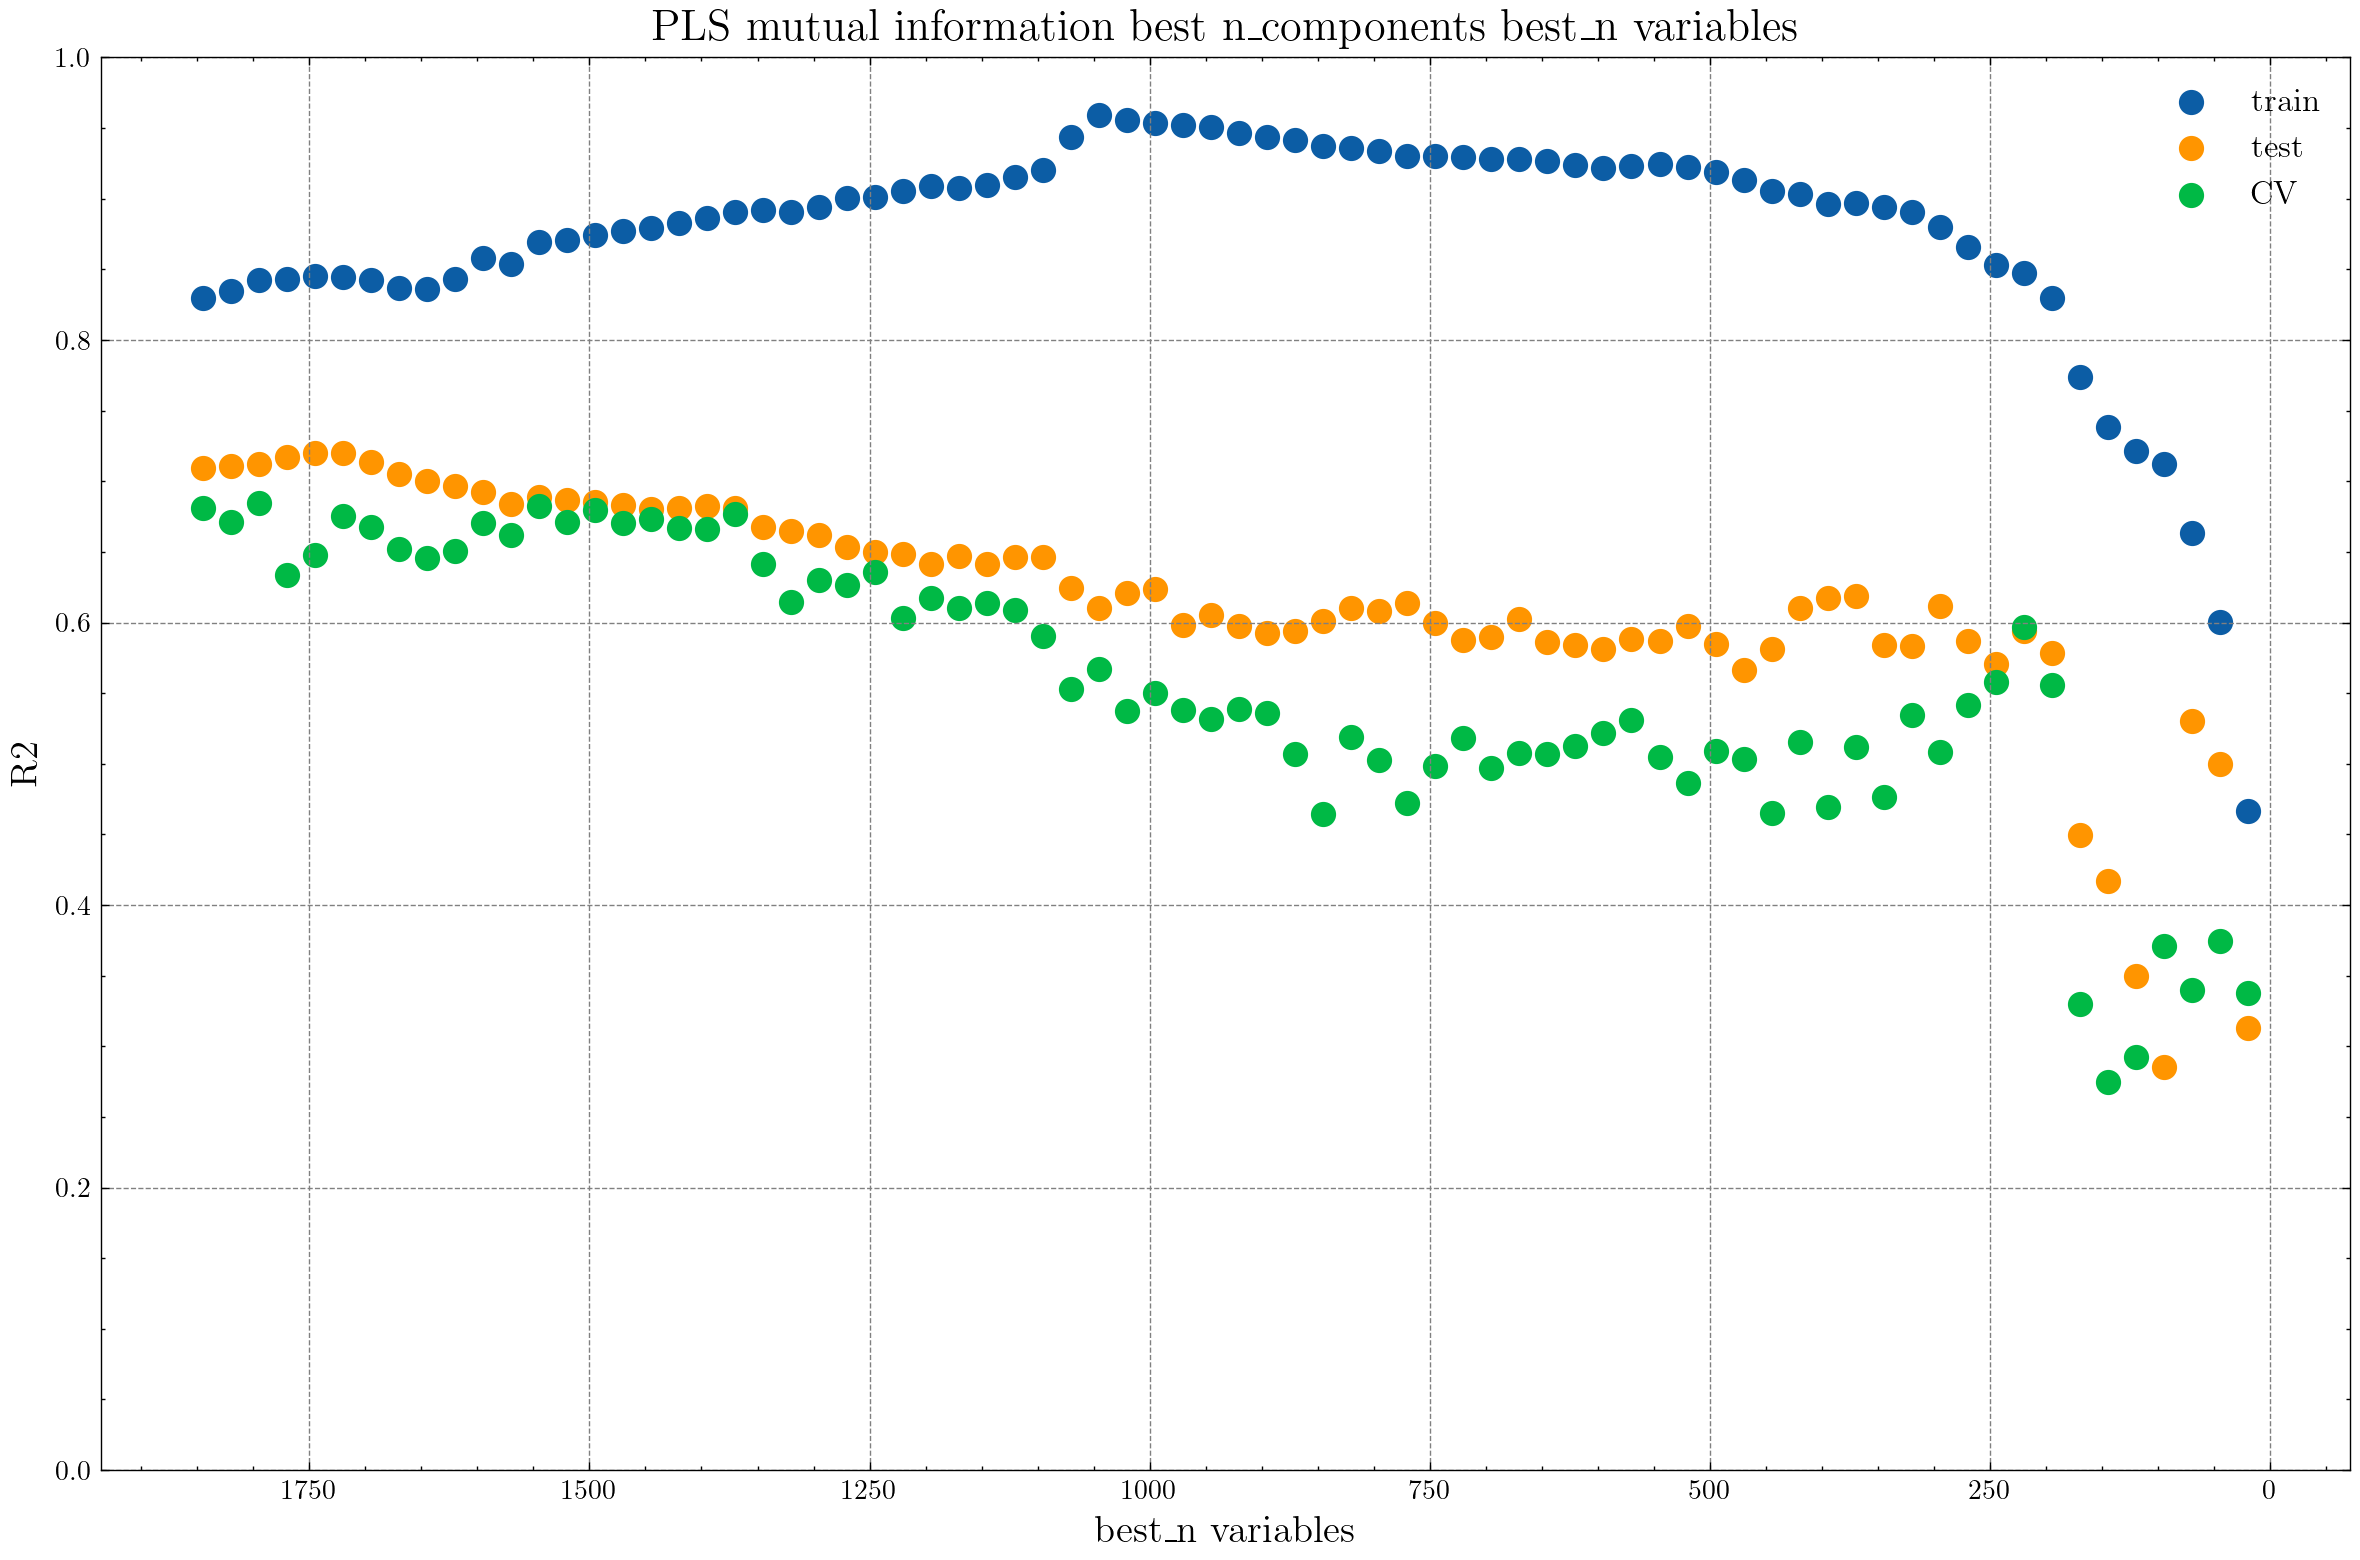

In [40]:
plt.style.use('science')

plt.figure(figsize=(12, 8), dpi=200)  # Increase the DPI for better quality

plt.scatter(table['top_n'], table['train r2'], color='C0', s=50, marker='o', label='train', linewidths=2)
plt.scatter(table['top_n'], table['test r2'], color='C2', s=50, marker='o', label='test', linewidths=2)
plt.scatter(table['top_n'], table['CV'], color='C1', s=50, marker='o', label='CV', linewidths=2)

plt.ylim(0, 1)
plt.gca().invert_xaxis()

plt.ylabel('R2', fontsize=14)
plt.xlabel('best_n variables', fontsize=14)
plt.title('PLS mutual information best n_components best_n variables', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')  # Subtle grid lines

plt.legend(fontsize=12)
plt.tight_layout()  # This can help with fitting everything neatly

### Neural network setup

In [9]:
#convert, pandas to loader
def make_loader(X,y,batch):
    if not isinstance(X, pd.DataFrame):
        try:
            X = pd.DataFrame(X)
        except ValueError:
            print("X cannot be converted to a pandas DataFrame.")
    
    if not isinstance(y, pd.Series):
        try:
            y = pd.Series(y)
        except ValueError:
            print("X cannot be converted to a pandas Series.")        
            
    x_tensor=torch.tensor(X.values, dtype=torch.float32)
    y_tensor=torch.tensor(y.values, dtype=torch.float32)
    set_object=TensorDataset(x_tensor,y_tensor)
    loader_object=DataLoader(dataset=set_object,batch_size=batch)
    return loader_object

In [10]:
#NN class
class NeuralNetwork(nn.Module):
    def __init__(self,input_size):
        super(NeuralNetwork,self).__init__()
        
        self.linear1=nn.Linear(input_size,6)
        self.activation1=nn.Tanh()
        self.linear2=nn.Linear(6,1)
        self.activation2=nn.Sigmoid()  
              
    def forward(self,x):
        x=self.linear1(x)
        x=self.activation1(x)
        x=self.linear2(x)
        x=self.activation2(x)
        return x

In [11]:
#early stop criterion
class EarlyStopper:
    def __init__(self, patience, min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.last_loss = float('inf')

    def early_stop(self, loss):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
        elif loss > self.last_loss:  # Spike detection
            pass  # Do nothing if a spike is detected
        else:
            self.counter += 1  # Increment if no improvement or no spike
            if self.counter >= self.patience:
                return True
        
        self.last_loss = loss
        return False

In [12]:
#train a single epoch
def train_one_epoch(TrainLoader, model, loss_fn, optimizer):
    model.train() 
    #train for every example in the dataloader
    for X_train,y_train in TrainLoader:
            
        pred_train=model(X_train)
        loss_train=loss_fn(pred_train,y_train.unsqueeze(1))
            
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
    return model

In [13]:
#evaluate once
def evaluate(Loader, model, loss_fn):
    loss_sum=0
    with torch.no_grad():
        for batch, (X,y) in enumerate(Loader):
            pred=model(X)
            loss=loss_fn(pred,y.unsqueeze(1))
            loss_sum+=loss.item()
            
    loss_sum/=len(Loader)
    
    return loss_sum

In [14]:
#train and store all errors =)
def train_fn(TrainLoader, TestLoader, model, loss_fn, optimizer,epochs):
    train_loss_epochs=[]
    test_loss_epochs=[]
    
    model.train() 
    
    for epoch in range(epochs):
        #train for every example in the dataloader
        for X_train,y_train in TrainLoader:
            
            pred_train=model(X_train)
            loss_train=loss_fn(pred_train,y_train.unsqueeze(1))
            
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
    
        loss_train_curr_epoch=evaluate(TrainLoader,model,loss_fn)
        train_loss_epochs.append(loss_train_curr_epoch)
       
        loss_test_curr_epoch=evaluate(TestLoader,model,loss_fn)
        test_loss_epochs.append(loss_test_curr_epoch)
        
    return model, train_loss_epochs, test_loss_epochs

In [15]:
#train and store all errors =)
def train_early_stop(TrainLoader, TestLoader, model, loss_fn, optimizer,max_epochs):
    train_loss_epochs=[]
    test_loss_epochs=[]
    
    model.train() 
    
    early_stopper = EarlyStopper(patience=2000, min_delta=0.00005)
    
    for epoch in range(max_epochs):
        #train for every example in the dataloader
        model=train_one_epoch(TrainLoader=TrainLoader, model=model, loss_fn=loss_fn, optimizer=optimizer)
    
        loss_train_curr_epoch=evaluate(TrainLoader,model,loss_fn)
        train_loss_epochs.append(loss_train_curr_epoch)
       
        loss_test_curr_epoch=evaluate(TestLoader,model,loss_fn)
        test_loss_epochs.append(loss_test_curr_epoch)
        
        if early_stopper.early_stop(loss=loss_train_curr_epoch):        
            break
        
    return model, train_loss_epochs, test_loss_epochs

In [16]:
#train and not store errors
def train_early_stop_no_loss(TrainLoader, model, loss_fn, optimizer,max_epochs):
    model.train() 
    
    early_stopper = EarlyStopper(patience=2000, min_delta=0.00005)
    
    for epoch in range(max_epochs):
        #train for every example in the dataloader
        model=train_one_epoch(TrainLoader=TrainLoader, model=model, loss_fn=loss_fn, optimizer=optimizer)
       
        loss_train_curr_epoch=evaluate(TrainLoader,model,loss_fn)
        
        if early_stopper.early_stop(loss=loss_train_curr_epoch):             
            break
        
    return model, epoch

In [17]:
def r2_score_model(model, loader):
    true_values = []
    predictions = []
    
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in loader:
            outputs = model(inputs)  # Get model predictions
            predictions.extend(outputs.numpy())  # Store predictions
            true_values.extend(labels.numpy())  # Store true labels
    
    # Calculate R^2 score
    return r2_score(true_values, predictions)

In [18]:
#simple function to initialize parameters, also work as a 'reset' of parameters
def ini_model(input,epochs=200):
    torch.manual_seed(0)
    model=NeuralNetwork(input_size=input)
    loss_fn=nn.MSELoss()
    optimizer=optim.Adam(model.parameters(),
                         lr=0.001,
                         weight_decay=0)
    return model,loss_fn,optimizer,epochs

In [19]:
#simple function to initialize parameters, also work as a 'reset' of parameters
def ini_model_seed(input,seed,epochs=200):
    torch.manual_seed(seed)
    model=NeuralNetwork(input_size=input)
    loss_fn=nn.MSELoss()
    optimizer=optim.Adam(model.parameters(),
                         lr=0.001,
                         weight_decay=0)
    return model,loss_fn,optimizer,epochs

### Neural Network troubleshooting

In [64]:
train_loader=make_loader(X=x_train,y=y_train,batch=2000)
test_loader=make_loader(X=x_test,y=y_test,batch=2000)

model,loss_fn,optimizer,epochs=ini_model(input=x_train.shape[1])

In [65]:
model, train_loss, test_loss=train_fn(TrainLoader=train_loader,
                                      TestLoader=test_loader, 
                                      model=model, 
                                      loss_fn=loss_fn, 
                                      optimizer=optimizer,
                                      epochs=1)

In [66]:
model, train_loss, test_loss=train_early_stop(TrainLoader=train_loader,
                                             TestLoader=test_loader,
                                             model=model,
                                             loss_fn=loss_fn,
                                             optimizer=optimizer,
                                             max_epochs=6000)

In [67]:
a=r2_score_model(model=model,loader=test_loader)

In [68]:
a

0.6990630437023577

In [69]:
parou_no=len(train_loss)
parou_no

6000

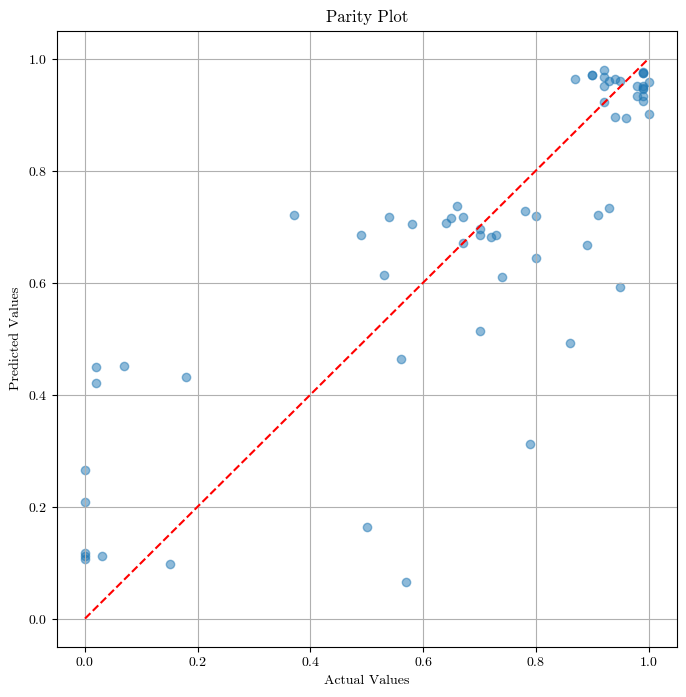

In [70]:
import matplotlib.pyplot as plt
import torch

# Assuming you have a 'model' and 'test_loader'
model.eval()  # Set the model to evaluation mode
actuals = []
predictions = []

with torch.no_grad():  # No need to track the gradients
    for inputs, labels in test_loader:
        outputs = model(inputs)  # Get the model's predictions
        
        # Assuming regression task and outputs are raw scores, not probabilities
        # If classification, you might need to apply a threshold or take the argmax
        predicted = outputs.squeeze().detach().cpu().numpy()  # Convert to numpy array
        actual = labels.detach().cpu().numpy()
        
        actuals.extend(actual)  # Append the labels to the actuals list
        predictions.extend(predicted)  # Append the predictions to the predictions list

# Now actuals and predictions are filled with the test data and model's predictions

# Create the parity plot
plt.figure(figsize=(8, 8))  # Set the figure size
plt.scatter(actuals, predictions, alpha=0.5)  # Create a scatter plot
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')  # Plot the perfect prediction line
plt.xlabel('Actual Values')  # Set the x-axis label
plt.ylabel('Predicted Values')  # Set the y-axis label
plt.title('Parity Plot')  # Set the title of the plot
plt.grid(True)  # Turn on the grid
plt.show()  # Display the plot


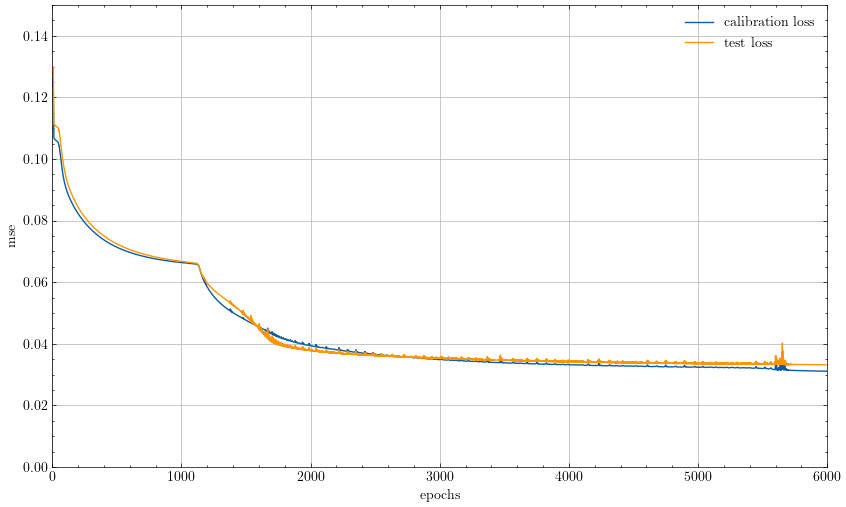

In [71]:
import scienceplots
plt.style.use('science')
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(train_loss)),train_loss,label='calibration loss',color='C0')
plt.plot(np.arange(len(test_loss)),test_loss,label='test loss',color='C2')
#plt.axvline(x=parou_no,color='g')
plt.legend()
plt.xlim(000,6000)
plt.ylim(0.0,0.15)
plt.xlabel('epochs')
plt.ylabel('mse')
plt.grid()

###  NNPermutation importance functions

In [61]:
#permutation importance from scikitlearn internally uses the predict function and checks for the presence
#of the fit function. if i feed my pytorch model inside a wrapper scikitlearn allows me tu use it's function =)
class PyTorchRegressorWrapper:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        #this function only needs to exhist to fulfill API contract with scikitlearn
        pass

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            #convert to numpy as needed
            if isinstance(X, pd.DataFrame):
                X = X.to_numpy()

            X_tensor = torch.tensor(X, dtype=torch.float32)
            predictions = self.model(X_tensor).numpy()
        return predictions

In [62]:
#function to evaluate permutation importance, evaluate on every fold, also stores learning curves...
def permutation_importance_loss_nn(X_train,y_train,k_folds):
    
    if not isinstance(X_train, pd.DataFrame):
        try:
            X_train = pd.DataFrame(X_train)
        except ValueError:
            print("X cannot be converted to a pandas DataFrame.")
    
    if not isinstance(y_train, pd.Series):
        try:
            y_train = pd.Series(y_train)
        except ValueError:
            print("X cannot be converted to a pandas Series.")        
               
    kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)

    cross_importances=np.zeros((X_train.shape[1],kfold.n_splits))

    train_loss_fold=[[],[],[],[],[]]
    val_loss_fold=[[],[],[],[],[]]
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
        
        x_train_fold=X_train.iloc[np.sort(train_idx)]
        y_train_fold=y_train.iloc[np.sort(train_idx)]
        x_val_fold=X_train.iloc[np.sort(val_idx)]
        y_val_fold=y_train.iloc[np.sort(val_idx)]
        
        train_loader_fold=make_loader(X=x_train_fold,y=y_train_fold,batch=2000)
        test_loader_fold=make_loader(X=x_val_fold,y=y_val_fold,batch=2000)

        model,loss_fn,optimizer,epochs=ini_model(input=x_train.shape[1]) #epochs defined inside function
        
        model, train_loss_fold[fold], val_loss_fold[fold]=train_early_stop(TrainLoader=train_loader_fold,
                                                                            TestLoader=test_loader_fold,
                                                                            model=model,
                                                                            loss_fn=loss_fn,
                                                                            optimizer=optimizer,
                                                                            max_epochs=6000)
        
        # pass model trough wrapper
        model_wrapper = PyTorchRegressorWrapper(model=model)

        # permutation importance with the wrapper instance
        results = permutation_importance(model_wrapper,
                                        x_val_fold,
                                        y_val_fold,
                                        n_repeats=30,
                                        random_state=42,
                                        n_jobs=4,
                                        scoring='neg_mean_squared_error')
        
        cross_importances[:,fold]=results.importances_mean
        
    return cross_importances, train_loss_fold, val_loss_fold


In [63]:
#this function returns the indexes to slice the n most important features
def perm_imp_get_topn_indexes(perm_imp_output,top_n):
    
    best_n=perm_imp_output.sort_values().head(top_n).index
    
    return best_n

In [64]:
#A
def build_table_nn_perm_imp(x_train,y_train,x_test,y_test,step,perm_imp_array,k_folds):
    #here i used the terms calibration and train somewhat interchangeably
    #the idea is that the complete train set without fold separation to be called calibration
    #the fold used to generate the model is train and the fold used to validade is validation...
    columns=['train mse','train std','val mse','val std','calibration mse','test mse','epochs','top_n','CV_mean_r2','CV_std_r2','test_r2','train_r2']
    stored = pd.DataFrame(columns=columns)

    for features in tqdm(range(x_train.shape[1],1800,-step)):
        
        important_idx=perm_imp_get_topn_indexes(perm_imp_output=perm_imp_array,
                                                top_n=features)
    
        x_train_reduced=x_train[important_idx.sort_values()]
        x_test_reduced=x_test[important_idx.sort_values()]
        
        kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)
        
        train_mse_fold=[]
        val_mse_fold=[]
        cross_folds_r2=[]
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train_reduced)):
        
            x_train_fold=x_train_reduced.iloc[np.sort(train_idx)]
            y_train_fold=y_train.iloc[np.sort(train_idx)]
            x_val_fold=x_train_reduced.iloc[np.sort(val_idx)]
            y_val_fold=y_train.iloc[np.sort(val_idx)]
            
            train_loader_fold=make_loader(X=x_train_fold,y=y_train_fold,batch=2000)
            val_loader_fold=make_loader(X=x_val_fold,y=y_val_fold,batch=2000)

            model,loss_fn,optimizer, _ =ini_model(input=features)#epochs defined inside function
           
            model,_ =train_early_stop_no_loss(TrainLoader=train_loader_fold,
                                           model=model,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           max_epochs=6000)
            
            train_loss_single_fold=evaluate(Loader=train_loader_fold, model=model, loss_fn=loss_fn)
            val_loss_single_fold=evaluate(Loader=val_loader_fold, model=model, loss_fn=loss_fn)
            r2_fold=r2_score_model(model=model,loader=val_loader_fold)
            
            train_mse_fold.append(train_loss_single_fold)
            val_mse_fold.append(val_loss_single_fold)
            cross_folds_r2.append(r2_fold)
            
        train_loader=make_loader(X=x_train_reduced,y=y_train,batch=2000)
        test_loader=make_loader(X=x_test_reduced,y=y_test,batch=2000)

        model,loss_fn,optimizer, _ =ini_model(input=features) #definedinside function
        model, epoch=train_early_stop_no_loss(TrainLoader=train_loader,
                                           model=model,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           max_epochs=6000)
        
        train_r2=r2_score_model(model=model,loader=train_loader)
        test_r2=r2_score_model(model=model,loader=test_loader)
         
        train_loss=evaluate(Loader=train_loader, model=model, loss_fn=loss_fn)
        val_loss=evaluate(Loader=test_loader, model=model, loss_fn=loss_fn)
        
        #['avg train mse','std train mse,'avg val mse','std val mse','calibration mse','test mse']
        avg_loss_train_fold=np.mean(train_mse_fold)
        std_loss_train_fold=np.std(train_mse_fold)
        avg_loss_val_fold=np.mean(val_mse_fold)
        std_loss_val_fold=np.std(val_mse_fold)
        CV_mean_r2=np.mean(cross_folds_r2)
        CV_std_r2=np.std(cross_folds_r2)
        # columns=['train mse','train std','val mse','val std','calibration mse','test mse','epochs','top_n','CV_mean_r2','CV_std_r2','test_r2','train_r2']
        stored.loc[features] = [avg_loss_train_fold,
                                std_loss_train_fold,
                                avg_loss_val_fold,
                                std_loss_val_fold,
                                train_loss,
                                val_loss,
                                epoch,
                                features,
                                CV_mean_r2,
                                CV_std_r2,
                                test_r2,
                                train_r2]
            
    return stored

In [65]:
#check consistency by intersection
def check_intersections(df,top_n):
    col=df.columns
    matrix=np.zeros((5,5),dtype=float)
    top_idx=[]
    for i in range(1,6):
        top_idx.append(set(perm_imp_get_topn_indexes(perm_imp_output=df['fold'+str(i)],top_n=top_n)))
        
    for i in range(0,5):
        for j in range(0,5):
            if j<=j:
                intersec_acc=len(top_idx[i] & top_idx[j])/top_n
                matrix[i,j]=intersec_acc
                matrix[j,i]=intersec_acc
    #eturn top_idx
    return pd.DataFrame(matrix, index=col, columns=col)

### NN permutation importance benchmark

In [66]:
importances,train_loss_list,val_loss_list=permutation_importance_loss_nn(X_train=x_train,
                                                                      y_train=y_train,
                                                                      k_folds=5)

In [67]:
#pre processing necessary, assume the correct ranking of each feature is the median value among folds...
importance_rank=pd.DataFrame(importances).rank(ascending=False)
importance_rank_named=importance_rank.rename(columns={0:'fold1',1:'fold2',2:'fold3',3:'fold4',4:'fold5'})
#importance_overall_rank=importance_rank_named.mean(axis=1)
importance_overall_rank=importance_rank_named.median(axis=1) #using median is more robust to outliers 

In [68]:
#check consistency by intersection
check_intersections(importance_rank_named,950).round(3)

,fold1,fold2,fold3,fold4,fold5
fold1,1.000,0.526,0.515,0.678,0.667
fold2,0.526,1.000,0.553,0.538,0.542
fold3,0.515,0.553,1.000,0.539,0.515
fold4,0.678,0.538,0.539,1.000,0.657
fold5,0.667,0.542,0.515,0.657,1.000


In [69]:
table=build_table_nn_perm_imp(x_train=x_train
                              ,y_train=y_train
                              ,x_test=x_test
                              ,y_test=y_test
                              ,step=50
                              ,perm_imp_array=importance_overall_rank
                              ,k_folds=5)

100%|██████████| 1/1 [04:39<00:00, 279.34s/it]


In [70]:
table

,train mse,train std,val mse,val std,calibration mse,test mse,epochs,top_n,CV_mean_r2,CV_std_r2,test_r2,train_r2
1845,0.059327,0.036315,0.068457,0.037053,0.031073,0.033177,5999.0,1845.0,0.354293,0.316944,0.69906,0.70543


In [125]:
table= build_table_nn_perm_imp_repeat(x_train=x_train
                               ,y_train=y_train
                               ,x_test=x_test
                               ,y_test=y_test
                               ,step=50
                               ,perm_imp_array=importance_overall_rank,
                               k_folds=5)


100%|██████████| 5/5 [45:18<00:00, 543.75s/it]


In [127]:
table

,train mse,train std,val mse,val std,calibration mse,test mse,epochs,top_n,CV_mean_r2,CV_std_r2,test_r2,train_r2
1845,0.090527,0.030527,0.091968,0.028114,0.031901,0.033169,5999.0,1845.0,0.117888,0.255297,0.699134,6.975790e-01
1795,0.105443,0.002874,0.105990,0.011492,0.105484,0.110257,2199.0,1795.0,-0.010935,0.005568,-0.000101,-4.833861e-07
1745,0.028015,0.002539,0.041283,0.010364,0.027957,0.032264,5999.0,1745.0,0.594901,0.129721,0.707345,7.349612e-01
1695,0.076396,0.037021,0.077800,0.031606,0.105484,0.110257,2201.0,1695.0,0.238622,0.317571,-0.000101,-4.471428e-07
1645,0.105443,0.002874,0.105990,0.011492,0.105484,0.110257,2131.0,1645.0,-0.010935,0.005568,-0.000101,-5.495182e-07


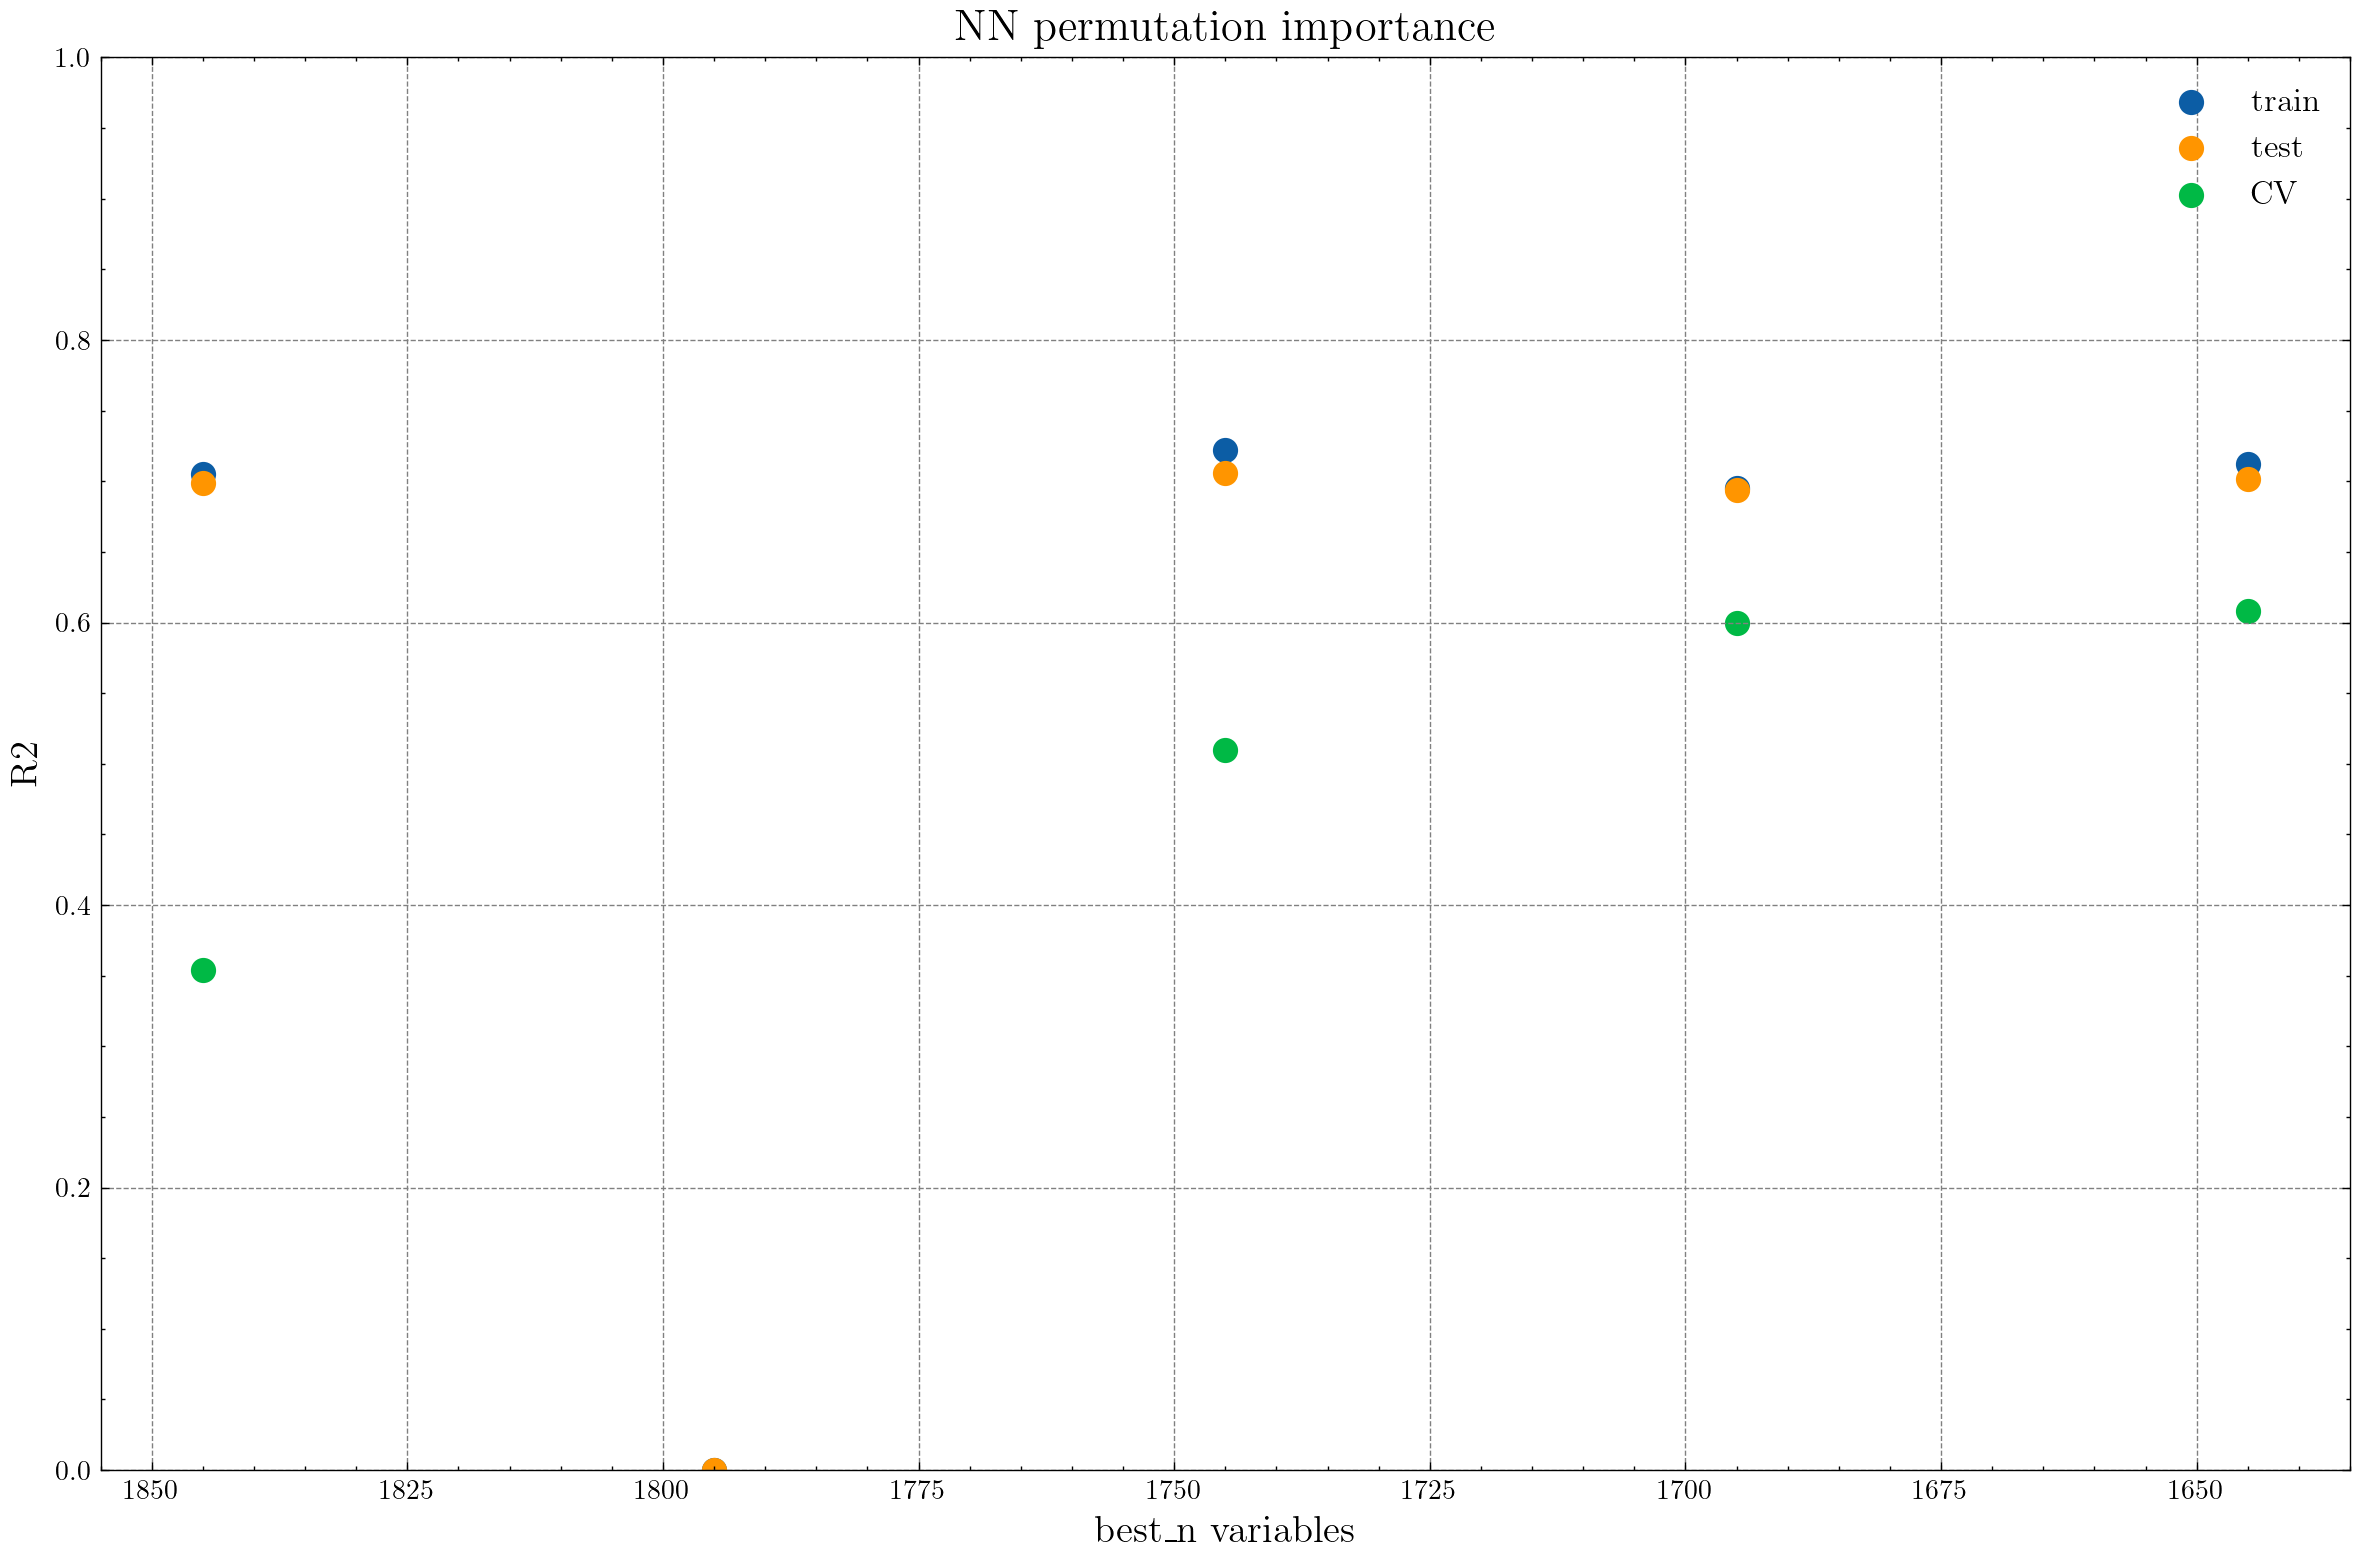

In [108]:
plt.style.use('science')

plt.figure(figsize=(12, 8), dpi=200)  # Increase the DPI for better quality

plt.scatter(table['top_n'], table['train_r2'], color='C0', s=50, marker='o', label='train', linewidths=2)
plt.scatter(table['top_n'], table['test_r2'], color='C2', s=50, marker='o', label='test', linewidths=2)
plt.scatter(table['top_n'], table['CV_mean_r2'], color='C1', s=50, marker='o', label='CV', linewidths=2)

plt.ylim(0, 1)
plt.gca().invert_xaxis()

plt.ylabel('R2', fontsize=14)
plt.xlabel('best_n variables', fontsize=14)
plt.title('NN permutation importance', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')  # Subtle grid lines

plt.legend(fontsize=12)
plt.tight_layout()  # This can help with fitting everything neatly

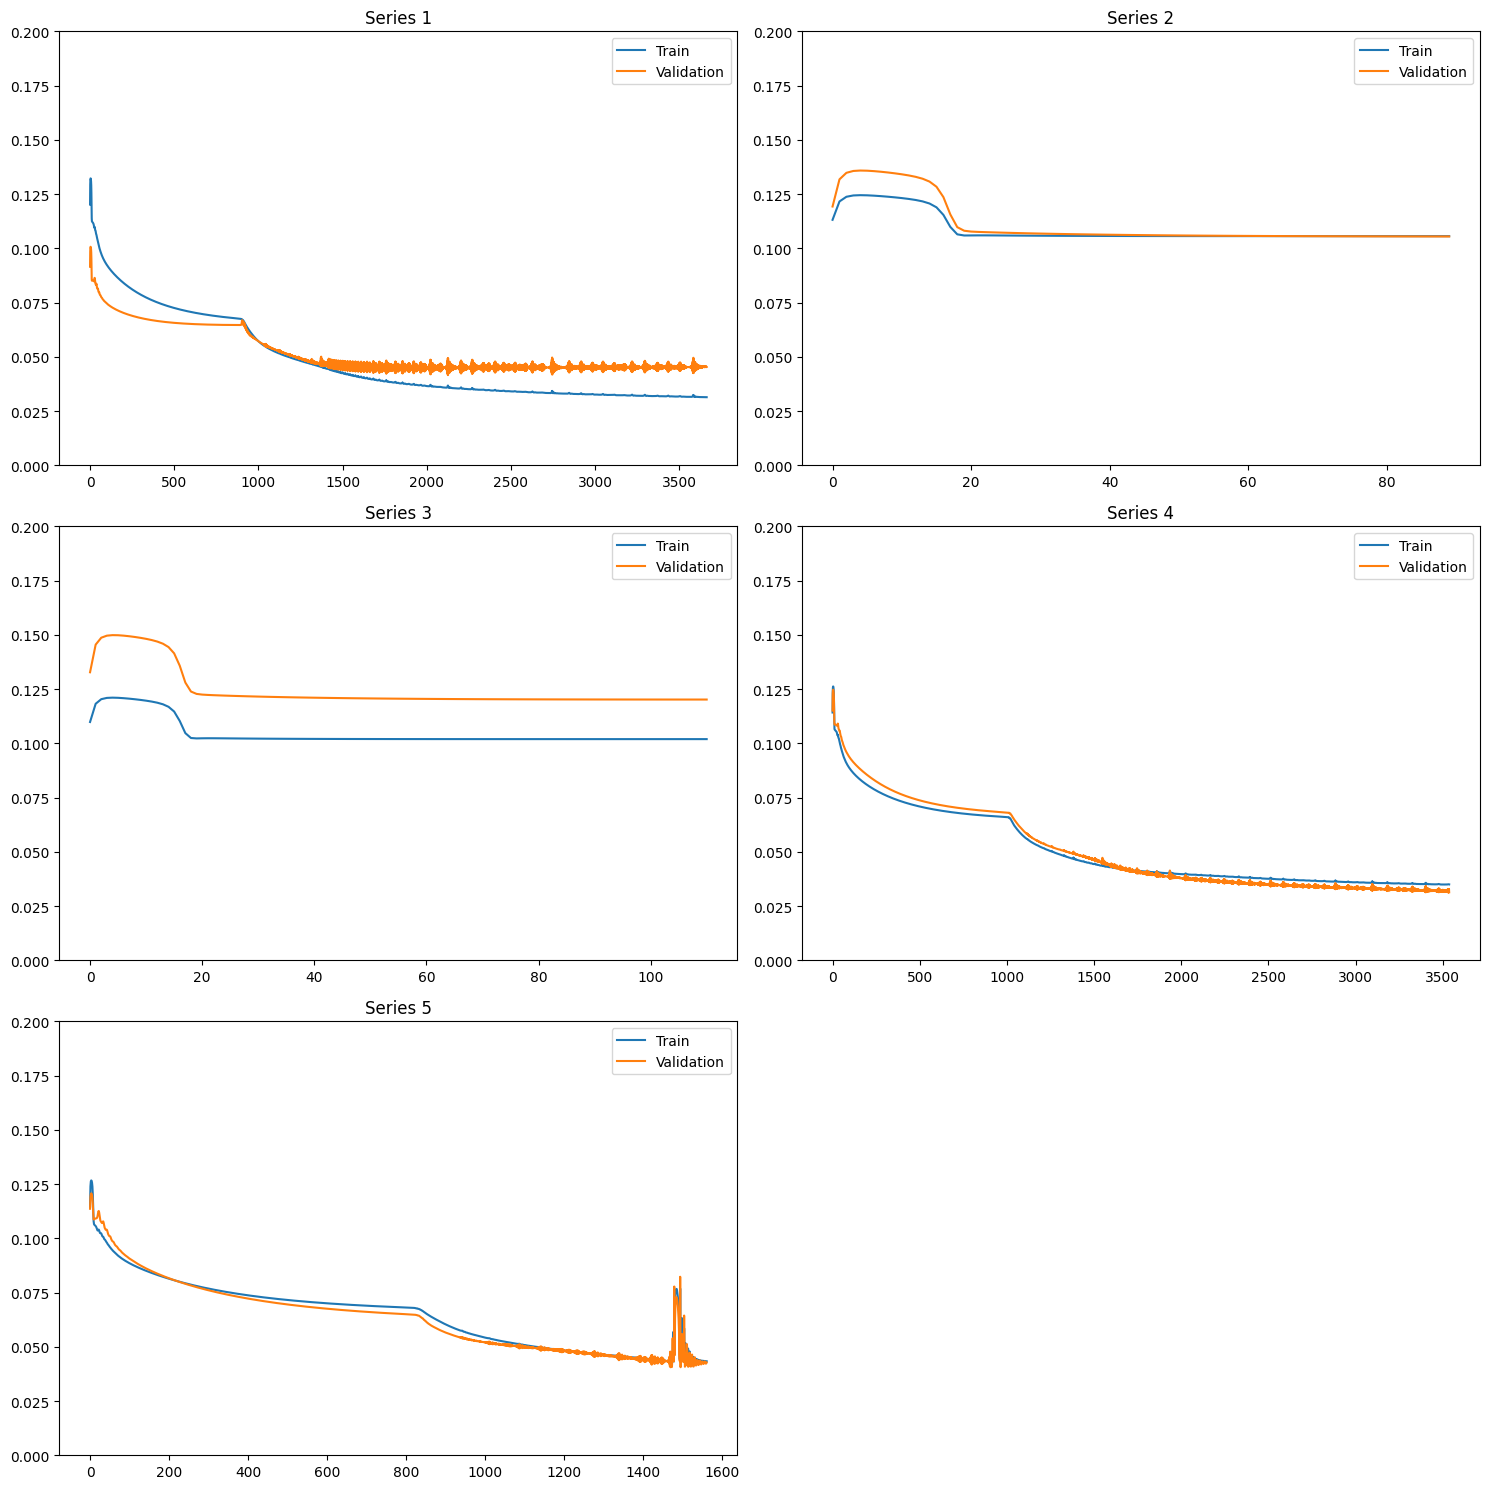

In [33]:
#loss plots on different folds
fig, axs = plt.subplots(3, 2, figsize=(15, 15))  # 3 rows, 2 columns

# flat so i can use indexing
axs_flat = axs.flatten()

for i in range(5):
    # Plot on subplot i
    axs_flat[i].plot(np.arange(len(train_loss_list[i])), train_loss_list[i], label='Train')
    axs_flat[i].plot(np.arange(len(val_loss_list[i])), val_loss_list[i], label='Validation')
    axs_flat[i].legend()
    axs_flat[i].set_title(f'Series {i+1}')
    axs_flat[i].set_ylim([0, 0.2])

# Hide the last subplot as it's unused
axs_flat[-1].axis('off')

plt.tight_layout()
plt.show()

### NN MI

In [89]:
def build_table_mi_nn(x_train,y_train,x_test,y_test,step,k_folds):
    #here i used the terms calibration and train somewhat interchangeably
    #the idea is that the complete train set without fold separation to be called calibration
    #the fold used to generate the model is train and the fold used to validade is validation...
    columns=['train mse','train std','val mse','val std','calibration mse','test mse','epochs','r2_test','r2_train','r2_cv_mean','r2_cv_std']
    stored = pd.DataFrame(columns=columns)

    mi_scores=mutual_info_regression(x_train,y_train,n_neighbors=3)

    for features in tqdm(range(x_train.shape[1], 1700, -step)):
        
        important_idx=pd.Series(mi_scores).sort_values(ascending=False).head(features).index
    
        x_train_selected=x_train[important_idx.sort_values()]
        x_test_selected=x_test[important_idx.sort_values()]
        
        kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)
        
        train_mse_fold=[]
        val_mse_fold=[]
        folds_r2=[]
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train)):
        
            x_train_fold=x_train_selected.iloc[np.sort(train_idx)]
            y_train_fold=y_train.iloc[np.sort(train_idx)]
            x_val_fold=x_train_selected.iloc[np.sort(val_idx)]
            y_val_fold=y_train.iloc[np.sort(val_idx)]
            
            train_loader_fold=make_loader(X=x_train_fold,y=y_train_fold,batch=2000)
            val_loader_fold=make_loader(X=x_val_fold,y=y_val_fold,batch=2000)

            model,loss_fn,optimizer, _ =ini_model(input=features)#epochs defined inside function

            model,_ =train_early_stop_no_loss(TrainLoader=train_loader_fold,
                                           model=model,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           max_epochs=6000)
            
            fold_r2=r2_score_model(model=model,loader=val_loader_fold)
            folds_r2.append(fold_r2)
            
            train_loss_single_fold=evaluate(Loader=train_loader_fold, model=model, loss_fn=loss_fn)
            val_loss_single_fold=evaluate(Loader=val_loader_fold, model=model, loss_fn=loss_fn)
            
            train_mse_fold.append(train_loss_single_fold)
            val_mse_fold.append(val_loss_single_fold)
        
        train_loader=make_loader(X=x_train_selected,y=y_train,batch=2000)
        test_loader=make_loader(X=x_test_selected,y=y_test,batch=2000)

        model,loss_fn,optimizer, _ =ini_model(input=features) #definedinside function
        model, epoch=train_early_stop_no_loss(TrainLoader=train_loader,
                                           model=model,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           max_epochs=6000)
        
        r2_cal=r2_score_model(model=model,loader=train_loader)
        r2_test=r2_score_model(model=model,loader=test_loader)
                
        train_loss=evaluate(Loader=train_loader, model=model, loss_fn=loss_fn)
        val_loss=evaluate(Loader=test_loader, model=model, loss_fn=loss_fn)
        
        avg_loss_train_fold=np.mean(train_mse_fold)
        std_loss_train_fold=np.std(train_mse_fold)
        avg_loss_val_fold=np.mean(val_mse_fold)
        std_loss_val_fold=np.std(val_mse_fold)
        
        r2_cv_mean = np.mean(folds_r2)
        r2_cv_std = np.std(folds_r2)
        
        stored.loc[features] = [avg_loss_train_fold,
                                std_loss_train_fold,
                                avg_loss_val_fold,
                                std_loss_val_fold,
                                train_loss,
                                val_loss,
                                epoch,
                                r2_test,
                                r2_cal,
                                r2_cv_mean,
                                r2_cv_std]
            
    return stored

In [90]:
table=build_table_mi_nn(x_train=x_train,
                  y_train=y_train,
                  x_test=x_test,
                  y_test=y_test,
                  step=50,
                  k_folds=5)

  0%|          | 0/3 [00:58<?, ?it/s]


KeyboardInterrupt: 

In [50]:
table['top_n']=table.index

In [51]:
table

,train mse,train std,val mse,val std,calibration mse,test mse,epochs,r2_test,r2_train,r2_cv,top_n
1845,0.063439,0.033174,0.069018,0.036363,0.033676,0.034747,3638.0,0.684819,0.680746,0.350375,1845
1795,0.105443,0.002874,0.105990,0.011498,0.105484,0.110256,95.0,-0.000087,-0.000001,-0.010924,1795
1745,0.105443,0.002874,0.105998,0.011491,0.105485,0.110258,111.0,-0.000107,-0.000003,-0.011010,1745
1695,0.105447,0.002874,0.105979,0.011478,0.105488,0.110262,106.0,-0.000149,-0.000034,-0.010846,1695
1645,0.105446,0.002874,0.105982,0.011494,0.105487,0.110260,160.0,-0.000127,-0.000029,-0.010858,1645
1595,0.032104,0.001242,0.038893,0.007357,0.033180,0.034587,2970.0,0.686272,0.685450,0.620643,1595
1545,0.032672,0.001447,0.039157,0.005420,0.033196,0.034395,3412.0,0.688014,0.685302,0.620241,1545
1495,0.031138,0.000882,0.037527,0.006939,0.031814,0.033406,3015.0,0.696990,0.698397,0.634955,1495
1445,0.032065,0.001404,0.038349,0.006039,0.031959,0.034027,4269.0,0.691353,0.697023,0.626256,1445
1395,0.031912,0.001065,0.038449,0.006194,0.032220,0.033761,3198.0,0.693768,0.694550,0.626209,1395


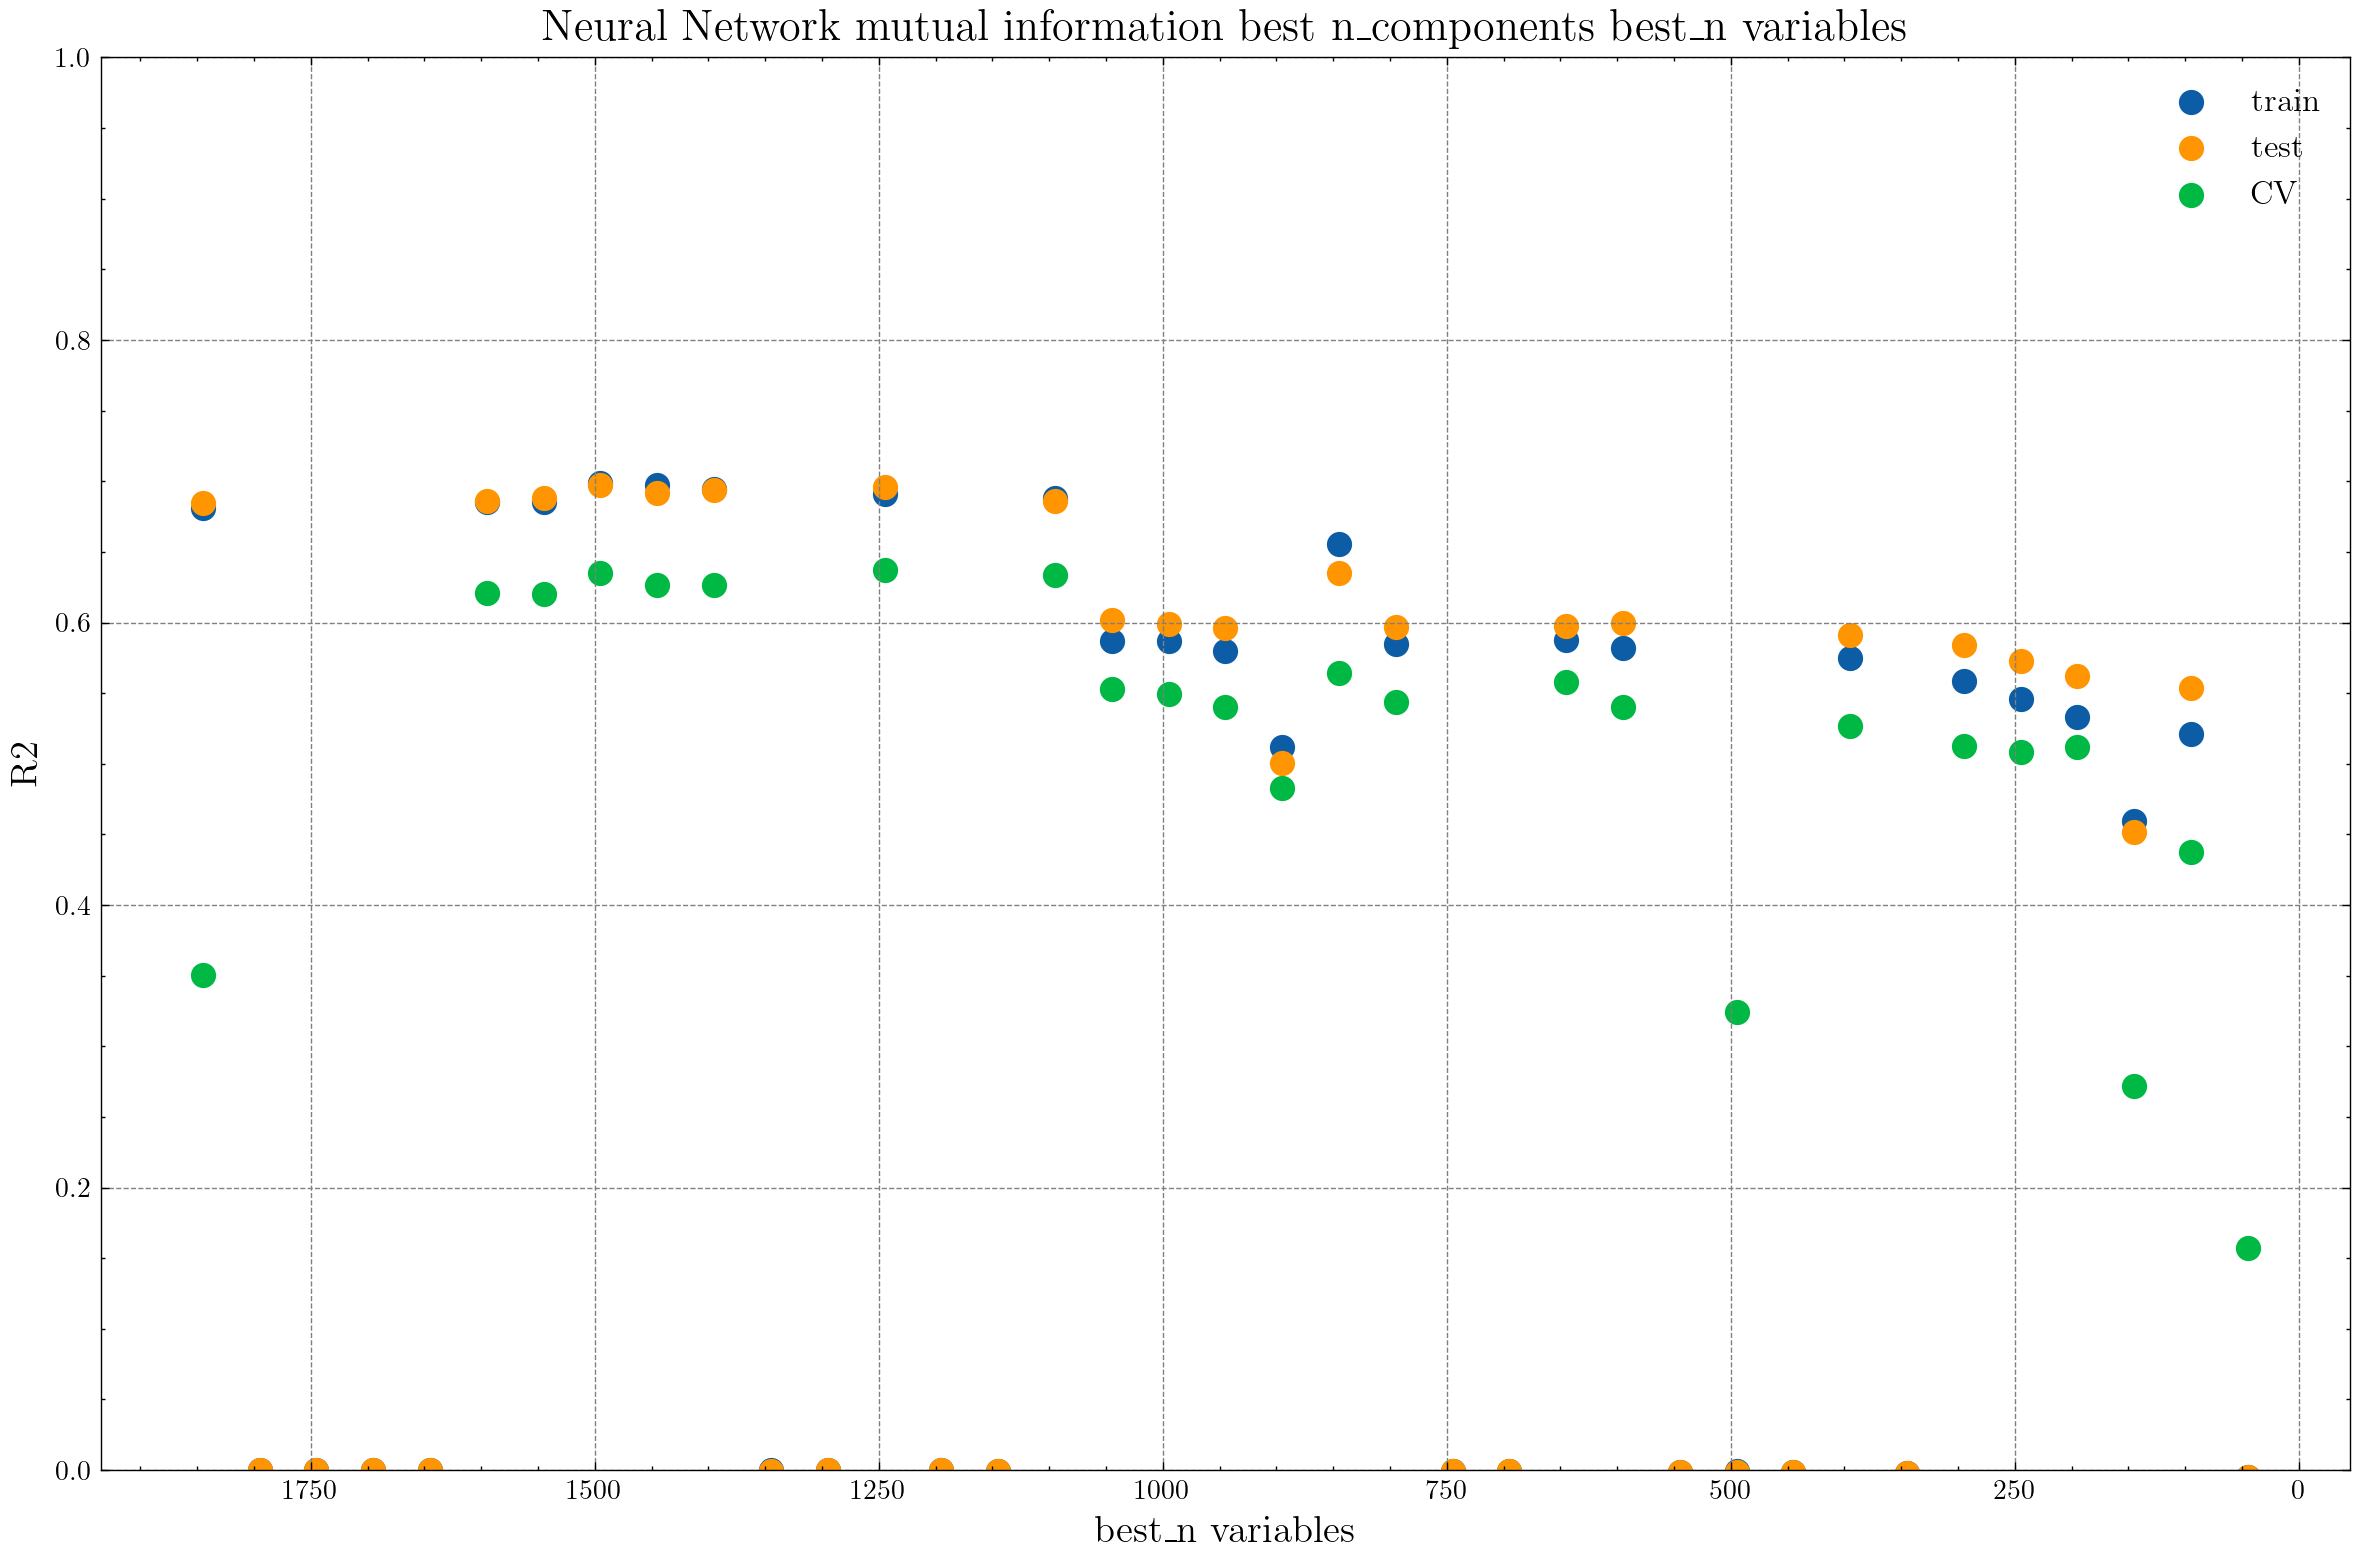

In [55]:
plt.style.use('science')

plt.figure(figsize=(12, 8), dpi=200)  # Increase the DPI for better quality

plt.scatter(table['top_n'], table['r2_train'], color='C0', s=50, marker='o', label='train', linewidths=2)
plt.scatter(table['top_n'], table['r2_test'], color='C2', s=50, marker='o', label='test', linewidths=2)
plt.scatter(table['top_n'], table['r2_cv'], color='C1', s=50, marker='o', label='CV', linewidths=2)

plt.ylim(0, 1)
plt.gca().invert_xaxis()

plt.ylabel('R2', fontsize=14)
plt.xlabel('best_n variables', fontsize=14)
plt.title('Neural Network mutual information best n_components best_n variables', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')  # Subtle grid lines

plt.legend(fontsize=12)
plt.tight_layout()  # This can help with fitting everything neatly

### PLS perm imp

In [15]:
#function to evaluate permutation importance, evaluate on every fold, also stores learning curves...
def permutation_importance_pls(X_train,y_train,k_folds,latent_variables):
    
    if not isinstance(X_train, pd.DataFrame):
        try:
            X_train = pd.DataFrame(X_train)
        except ValueError:
            print("X cannot be converted to a pandas DataFrame.")
    
    if not isinstance(y_train, pd.Series):
        try:
            y_train = pd.Series(y_train)
        except ValueError:
            print("X cannot be converted to a pandas Series.")        
               
    kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)

    cross_importances=np.zeros((x_train.shape[1],kfold.n_splits))

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
        
        x_train_fold=X_train.iloc[np.sort(train_idx)]
        y_train_fold=y_train.iloc[np.sort(train_idx)]
        x_val_fold=X_train.iloc[np.sort(val_idx)]
        y_val_fold=y_train.iloc[np.sort(val_idx)]
        
        pls=PLSRegression(n_components=latent_variables)
        pls.fit(x_train_fold,y_train_fold)
        
        results = permutation_importance(pls,
                                        x_val_fold,
                                        y_val_fold,
                                        n_repeats=30,
                                        random_state=42,
                                        n_jobs=4,
                                        scoring='neg_mean_squared_error')
        
        cross_importances[:,fold]=results.importances_mean
        
    return cross_importances

In [16]:
def build_table_pls(x_train,y_train,x_test,y_test,step,perm_imp_array,k_folds,latent_variables):
    #here i used the terms calibration and train somewhat interchangeably
    #the idea is that the complete train set without fold separation to be called calibration
    #the fold used to generate the model is train and the fold used to validade is validation...
    columns=['train mse','train std','val mse','val std','calibration mse','test mse','top_n','r2_train','r2_test','r2_cv']
    stored = pd.DataFrame(columns=columns)

    for features in np.arange(x_train.shape[1],1,-step):
        
        important_idx=perm_imp_get_topn_indexes(perm_imp_output=perm_imp_array,
                                                top_n=features)
    
        x_train_reduced=x_train[important_idx.sort_values()]
        x_test_reduced=x_test[important_idx.sort_values()]
        
        kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)
        
        train_mse_fold=[]
        val_mse_fold=[]
        val_r2_folds=[]
        for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train_reduced)):
        
            x_train_fold=x_train_reduced.iloc[np.sort(train_idx)]
            y_train_fold=y_train.iloc[np.sort(train_idx)]
            x_val_fold=x_train_reduced.iloc[np.sort(val_idx)]
            y_val_fold=y_train.iloc[np.sort(val_idx)]
            
            pls=PLSRegression(n_components=latent_variables)
            pls.fit(x_train_fold,y_train_fold)
            
            train_loss_single_fold=mean_squared_error(y_train_fold,pls.predict(x_train_fold))
            val_loss_single_fold=mean_squared_error(y_val_fold,pls.predict(x_val_fold))
            
            train_mse_fold.append(train_loss_single_fold)
            val_mse_fold.append(val_loss_single_fold)
            val_r2=r2_score(y_val_fold,pls.predict(x_val_fold))
            val_r2_folds.append(val_r2)

        pls=PLSRegression(n_components=latent_variables)
        pls.fit(x_train_reduced,y_train)
        
        train_loss=mean_squared_error(y_train,pls.predict(x_train_reduced))
        test_loss=mean_squared_error(y_test,pls.predict(x_test_reduced))
    
        #['avg train mse','std train mse,'avg val mse','std val mse','calibration mse','test mse']
        avg_loss_train_fold=np.mean(train_mse_fold)
        std_loss_train_fold=np.std(train_mse_fold)
        avg_loss_val_fold=np.mean(val_mse_fold)
        std_loss_val_fold=np.std(val_mse_fold)
        r2_train=r2_score(y_train,pls.predict(x_train_reduced))
        r2_test=r2_score(y_test,pls.predict(x_test_reduced))
        r2_cv=np.mean(val_r2_folds)
        
        stored.loc[features] = [avg_loss_train_fold,
                                std_loss_train_fold,
                                avg_loss_val_fold,
                                std_loss_val_fold,
                                train_loss,
                                test_loss,
                                features,
                                r2_train,
                                r2_test,
                                r2_cv]
            
    return stored

In [17]:
importances_pls=permutation_importance_pls(X_train=x_train,
                                           y_train=y_train,
                                           k_folds=5,
                                           latent_variables=16)

In [18]:

importance_rank=pd.DataFrame(importances_pls).rank(ascending=False)
importance_rank_named=importance_rank.rename(columns={0:'fold1',1:'fold2',2:'fold3',3:'fold4',4:'fold5'})
#importance_overall_rank=importance_rank_named.mean(axis=1)
importance_overall_rank_pls=importance_rank_named.median(axis=1) #using median is more robust to outliers 

In [26]:
a=check_intersections(importance_rank_named,900)
a.round(3)

,fold1,fold2,fold3,fold4,fold5
fold1,1.000,0.683,0.673,0.703,0.740
fold2,0.683,1.000,0.678,0.698,0.706
fold3,0.673,0.678,1.000,0.710,0.709
fold4,0.703,0.698,0.710,1.000,0.740
fold5,0.740,0.706,0.709,0.740,1.000


In [20]:
table = build_table_pls(x_train=x_train,
                        y_train=y_train,
                       x_test=x_test,
                       y_test=y_test,
                       step=25,
                       perm_imp_array=importance_overall_rank_pls,
                       k_folds=5,
                       latent_variables=16)

In [21]:
table

,train mse,train std,val mse,val std,calibration mse,test mse,top_n,r2_train,r2_test,r2_cv
1845,0.010559,0.000927,0.036532,0.008077,0.012925,0.032646,1845.0,0.877474,0.703883,0.642317
1820,0.010488,0.000918,0.036265,0.008036,0.012825,0.032733,1820.0,0.878415,0.703095,0.644684
1795,0.010434,0.000912,0.036245,0.008005,0.012763,0.032655,1795.0,0.879004,0.703795,0.644954
1770,0.010386,0.000916,0.036195,0.007978,0.012710,0.032625,1770.0,0.879510,0.704068,0.645475
1745,0.010388,0.000913,0.036097,0.007908,0.012712,0.032607,1745.0,0.879487,0.704233,0.646453
...,...,...,...,...,...,...,...,...,...,...
120,0.011038,0.000967,0.032397,0.008441,0.012554,0.035170,120.0,0.880985,0.680984,0.680281
95,0.013706,0.000496,0.032119,0.005608,0.015206,0.031316,95.0,0.855850,0.715943,0.685037
70,0.017861,0.000618,0.038971,0.004231,0.019565,0.039295,70.0,0.814520,0.643572,0.621824
45,0.025477,0.001297,0.043612,0.006845,0.026745,0.046108,45.0,0.746459,0.581775,0.576730


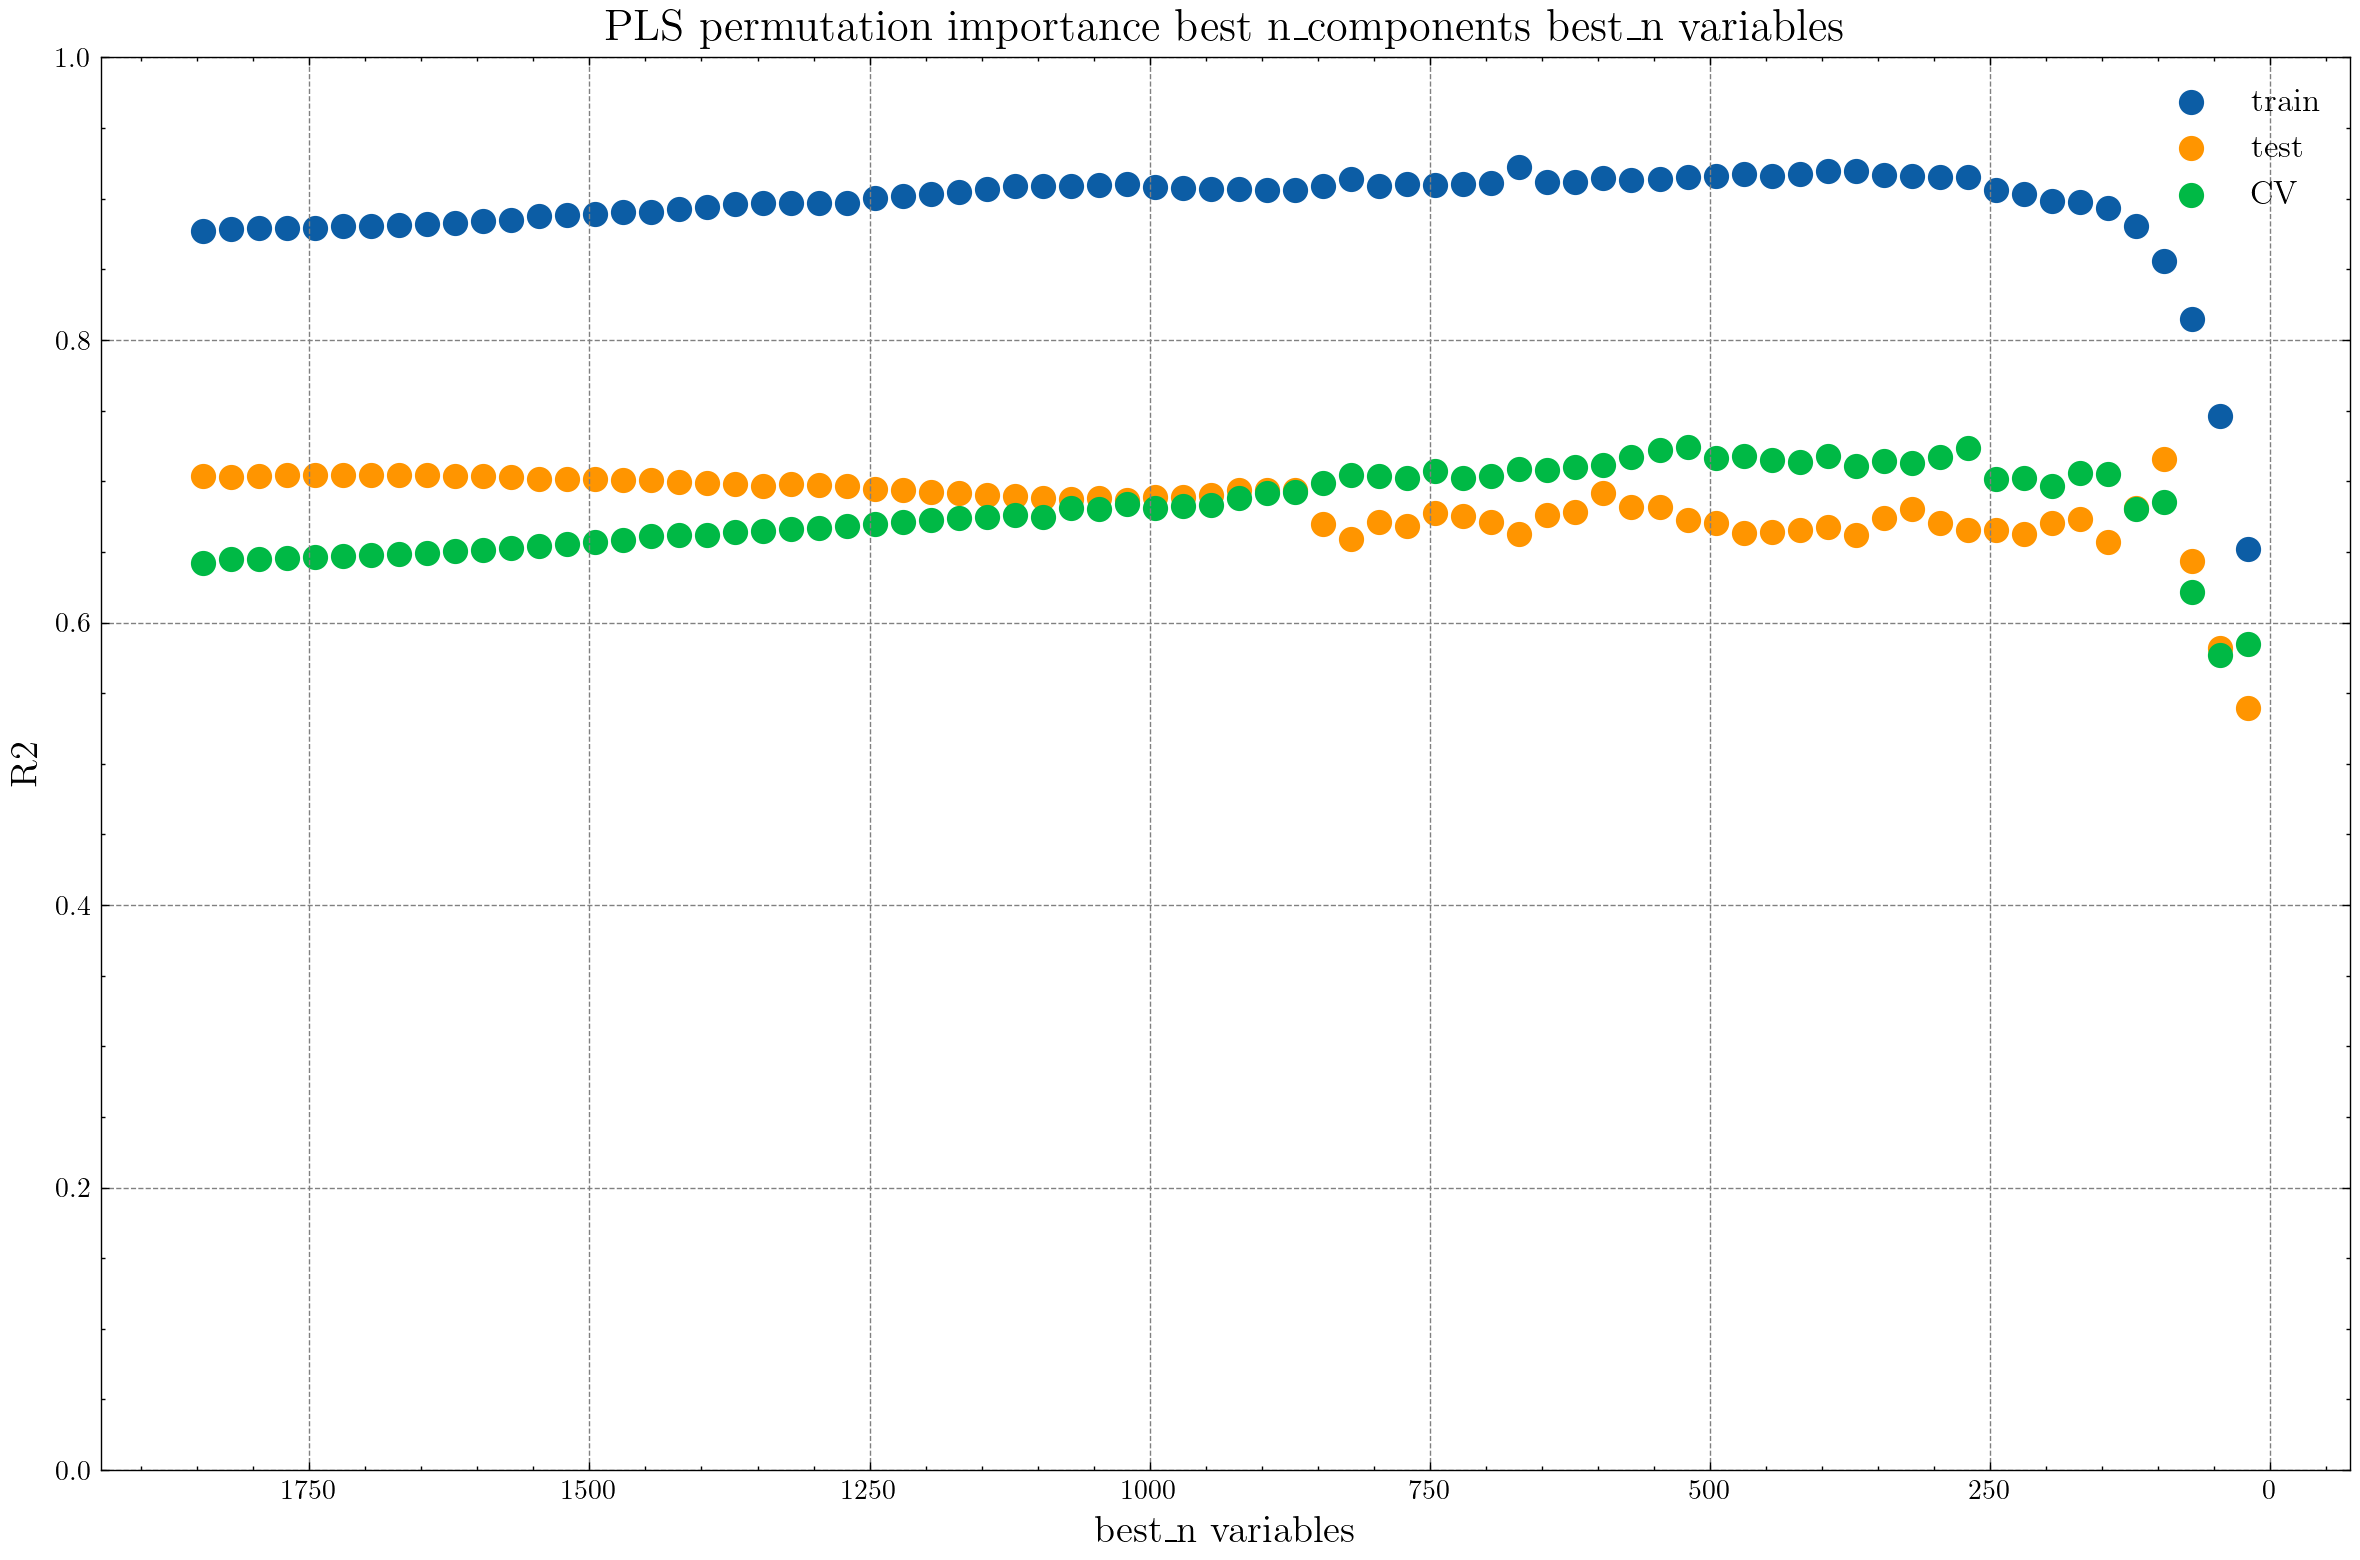

In [24]:
plt.style.use('science')

plt.figure(figsize=(12, 8), dpi=200)  # Increase the DPI for better quality

plt.scatter(table['top_n'], table['r2_train'], color='C0', s=50, marker='o', label='train', linewidths=2)
plt.scatter(table['top_n'], table['r2_test'], color='C2', s=50, marker='o', label='test', linewidths=2)
plt.scatter(table['top_n'], table['r2_cv'], color='C1', s=50, marker='o', label='CV', linewidths=2)

plt.ylim(0, 1)
plt.gca().invert_xaxis()

plt.ylabel('R2', fontsize=14)
plt.xlabel('best_n variables', fontsize=14)
plt.title('PLS permutation importance best n_components best_n variables', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')  # Subtle grid lines

plt.legend(fontsize=12)
plt.tight_layout()  # This can help with fitting everything neatly

In [ ]:
### terminar o PLS perm imp...

In [ ]:
a